# Spatial analysis of reconstructed human tonsil Slide-tags coordinate data 

The human tonsil data was first downloaded from the link provided in the Slide-tags article. Thereafter, it was processed in R with Seurat, including filtering of cells and subsetting the cells that were discarded in their original analysis but for which we were able to reconstruct their spatial positions. For these new cells, the cell type identities were inferred using the Seurat label transfer approach and using the originally annotated cell types.

The data can be split up into three groups:

- Dataset #1: Original cells, ground-truth positions ("ad_orig_gt")
- Dataset #2: Original cells, reconstructed positions ("ad_orig_rc")
- Dataset #3: Newly added cells, reconstructed positions ("ad_new_rc")

The aim is now to perform a set of different spatial-based analysis to deduce the potential loss of information happening due to the coordinate reconstruction (compared with ground truth). We also want to assess the labels and positions of the new cells by comparing their properties with dataset #2. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from anndata import AnnData

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

scanpy==1.10.3 anndata==0.10.8 umap==0.5.7 numpy==1.26.4 scipy==1.13.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13
squidpy==1.6.1


In [3]:
res_out_path = '/Users/lovisafranzen/Documents/PhD_Projects/slide-tags_hidden-network/slidetags-network/results/tonsil_data/'

## Prepare data

### Read all data

In [4]:
dat_orig_gt = sc.read_h5ad("/Users/lovisafranzen/Documents/PhD_Projects/slide-tags_hidden-network/slidetags-network/results/tonsil_data/se_data_orig_cells_gt_assayData.h5ad")

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [5]:
dat_orig_rc = sc.read_h5ad("/Users/lovisafranzen/Documents/PhD_Projects/slide-tags_hidden-network/slidetags-network/results/tonsil_data/se_data_orig_cells_rc_assayData.h5ad")

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [6]:
dat_new_rc = sc.read_h5ad("/Users/lovisafranzen/Documents/PhD_Projects/slide-tags_hidden-network/slidetags-network/results/tonsil_data/se_data_new_cells_filt_assayData.h5ad")

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [144]:
dat_orig_new_rc = sc.read_h5ad("/Users/lovisafranzen/Documents/PhD_Projects/slide-tags_hidden-network/slidetags-network/results/tonsil_data/se_data_orig_new_cells_filt_assayData.h5ad")

In [7]:
dat_orig_gt.X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.93766137, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.62965462,
        0.        ],
       ...,
       [1.31901235, 0.        , 0.        , ..., 0.        , 1.31901235,
        0.        ],
       [2.13764341, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.18592702, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [8]:
ad_orig_gt = AnnData(dat_orig_gt.X, 
                     obs = dat_orig_gt.obs,
                     uns = dat_orig_gt.uns,
                     obsm = {"spatial":dat_orig_gt.obs[['spatial_x', 'spatial_y']].to_numpy()})

In [9]:
ad_orig_gt.var_names = dat_orig_gt.var_names

In [10]:
dat_orig_rc.obs[['spatial_x', 'spatial_y']].head()

spatial_x    spatial_y
AAACCCAAGCGCCTTG-1  1743.472963  1787.347598
AAACCCAAGTGGACGT-1   348.563207  2101.918172
AAACCCACAGAAGTGC-1  1117.474355  2185.799021
AAACCCAGTCATTGCA-1  1816.808009  3451.313051
AAACCCATCATCGCAA-1   914.200218  2676.125760

In [11]:
ad_orig_rc = AnnData(dat_orig_rc.X, 
                     obs = dat_orig_rc.obs,
                     uns = dat_orig_rc.uns,
                     obsm = {"spatial":dat_orig_rc.obs[['spatial_x', 'spatial_y']].to_numpy()})

In [12]:
ad_orig_rc.var_names = dat_orig_rc.var_names

In [13]:
dat_new_rc.obs[['spatial_x', 'spatial_y']].head()

spatial_x    spatial_y
AAAGAACCAATCCAGT-1  2874.604760  2893.521223
AAAGAACCATCCGTTC-1  2059.096677  2058.954653
AAAGAACTCGACCAAT-1  1706.556410  1878.376377
AAAGGATCAAACAGGC-1  2120.931298  2297.555369
AAAGGATCAAGATTGA-1  1621.953603  2265.362410

In [14]:
ad_new_rc = AnnData(dat_new_rc.X, 
                    obs = dat_new_rc.obs,
                    uns = dat_new_rc.uns,
                    obsm = {"spatial":dat_new_rc.obs[['spatial_x', 'spatial_y']].to_numpy()})

In [15]:
ad_new_rc.var_names = dat_new_rc.var_names

Prepare a second `ad_orig_rc` object for morphed coordinates

In [16]:
dat_orig_rc.obs[['spatial_x_morph', 'spatial_y_morph']].head()

spatial_x_morph  spatial_y_morph
AAACCCAAGCGCCTTG-1      1726.860853      1735.075211
AAACCCAAGTGGACGT-1       477.905185      2102.744268
AAACCCACAGAAGTGC-1      1046.115276      2204.633234
AAACCCAGTCATTGCA-1      1827.395747      3382.673816
AAACCCATCATCGCAA-1       875.975261      2735.769716

In [296]:
# Modify coordinates to test if downstream results are different than using the regular rc coords
dat_orig_rc.obs['spatial_x_morph2'] = dat_orig_rc.obs['spatial_x_morph'].to_numpy() * np.random.uniform(1, 2, size=dat_orig_rc.obs.shape[0])
dat_orig_rc.obs['spatial_y_morph2'] = dat_orig_rc.obs['spatial_y_morph'].to_numpy() * np.random.uniform(1, 2, size=dat_orig_rc.obs.shape[0])

In [297]:
ad_orig_rc_morph = AnnData(dat_orig_rc.X, 
                           obs = dat_orig_rc.obs,
                           uns = dat_orig_rc.uns,
                           obsm = {"spatial":dat_orig_rc.obs[['spatial_x_morph', 'spatial_y_morph']].to_numpy()})

In [298]:
ad_orig_rc_morph.var_names = dat_orig_rc.var_names

Prepare a `ad_orig_new_rc` object for both original and new cells, reconstructed data

In [145]:
dat_orig_new_rc.obs[['spatial_x_morph', 'spatial_y_morph']].head()

spatial_x_morph  spatial_y_morph
AAACCCAAGCGCCTTG-1      1726.860853      1735.075211
AAACCCAAGTGGACGT-1       477.905185      2102.744268
AAACCCACAGAAGTGC-1      1046.115276      2204.633234
AAACCCAGTCATTGCA-1      1827.395747      3382.673816
AAACCCATCATCGCAA-1       875.975261      2735.769716

In [146]:
ad_orig_new_rc = AnnData(dat_orig_new_rc.X, 
                         obs = dat_orig_new_rc.obs,
                         uns = dat_orig_new_rc.uns,
                         obsm = {"spatial":dat_orig_new_rc.obs[['spatial_x_morph', 'spatial_y_morph']].to_numpy()})

In [272]:
ad_orig_new_rc.var_names = dat_orig_new_rc.var_names

### Inspect data

In [19]:
ad_orig_gt

AnnData object with n_obs × n_vars = 5631 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'barcode', 'UMAP_1', 'UMAP_2', 'cell_type', 'spatial_x', 'spatial_y', 'node_type', 'type_prediction_score', 'RNA_snn_res.0.75', 'seurat_clusters', 'seurat_clusters_mod', 'percent.mt'
    uns: 'neighbors'
    obsm: 'spatial'

In [20]:
ad_orig_rc

AnnData object with n_obs × n_vars = 5631 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'barcode', 'UMAP_1', 'UMAP_2', 'cell_type', 'spatial_x', 'spatial_y', 'node_type', 'type_prediction_score', 'RNA_snn_res.0.75', 'seurat_clusters', 'seurat_clusters_mod', 'percent.mt', 'spatial_x_morph', 'spatial_y_morph'
    uns: 'neighbors'
    obsm: 'spatial'

In [21]:
ad_new_rc

AnnData object with n_obs × n_vars = 1783 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'barcode', 'UMAP_1', 'UMAP_2', 'cell_type', 'spatial_x', 'spatial_y', 'node_type', 'type_prediction_score', 'percent.mt', 'RNA_snn_res.0.75', 'seurat_clusters', 'predicted.id', 'prediction.score.T_CD4', 'prediction.score.plasma', 'prediction.score.B_germinal_center', 'prediction.score.B_naive', 'prediction.score.B_memory', 'prediction.score.mDC', 'prediction.score.T_follicular_helper', 'prediction.score.NK', 'prediction.score.FDC', 'prediction.score.T_CD8', 'prediction.score.pDC', 'prediction.score.myeloid', 'prediction.score.T_double_neg', 'prediction.score.max', 'spatial_x_morph', 'spatial_y_morph'
    uns: 'neighbors'
    obsm: 'spatial'

In [22]:
ad_orig_rc_morph

AnnData object with n_obs × n_vars = 5631 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'barcode', 'UMAP_1', 'UMAP_2', 'cell_type', 'spatial_x', 'spatial_y', 'node_type', 'type_prediction_score', 'RNA_snn_res.0.75', 'seurat_clusters', 'seurat_clusters_mod', 'percent.mt', 'spatial_x_morph', 'spatial_y_morph'
    uns: 'neighbors'
    obsm: 'spatial'

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


<Axes: title={'center': 'node_type'}, xlabel='spatial1', ylabel='spatial2'>

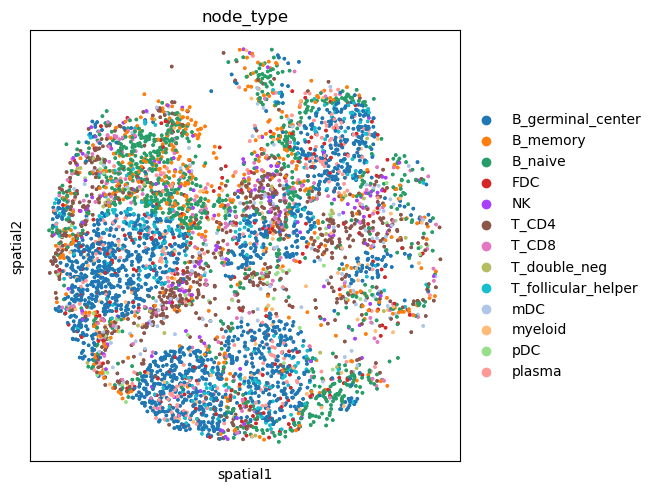

In [23]:
sq.pl.spatial_scatter(ad_orig_gt, color="node_type", size=10, shape=None, return_ax = True)

In [24]:
ad_orig_rc.obsm['spatial'][np.isnan(ad_orig_rc.obsm['spatial'])]

array([], dtype=float64)

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


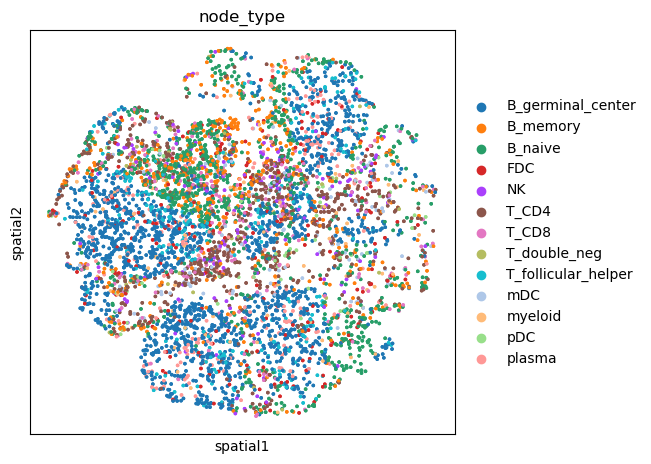

In [25]:
sq.pl.spatial_scatter(ad_orig_rc, color="node_type", size=10, shape=None)

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


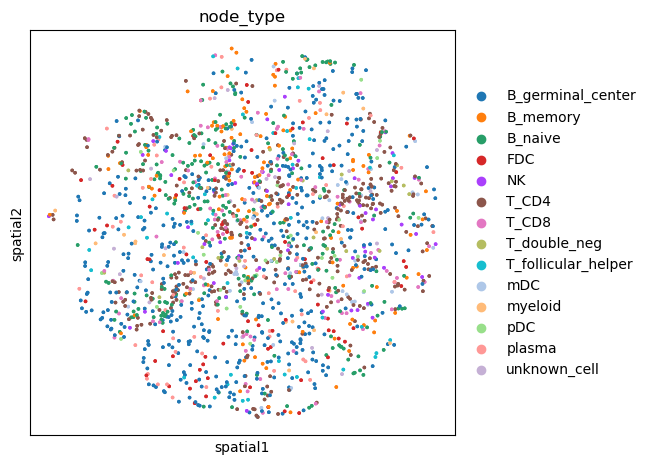

In [26]:
sq.pl.spatial_scatter(ad_new_rc, color="node_type", size=10, shape=None)

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


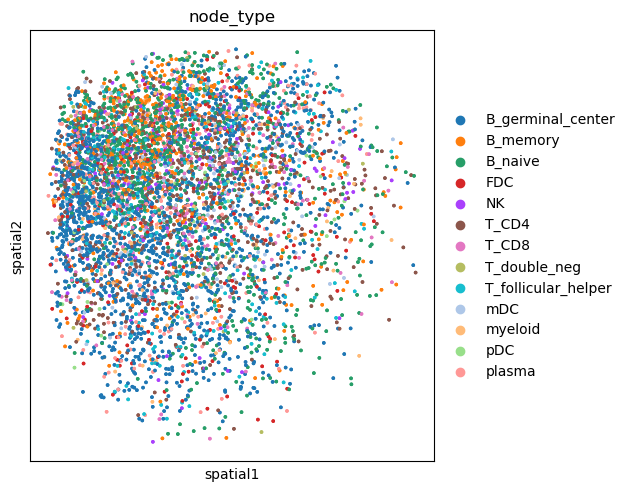

In [299]:
sq.pl.spatial_scatter(ad_orig_rc_morph, color="node_type", size=10, shape=None)

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


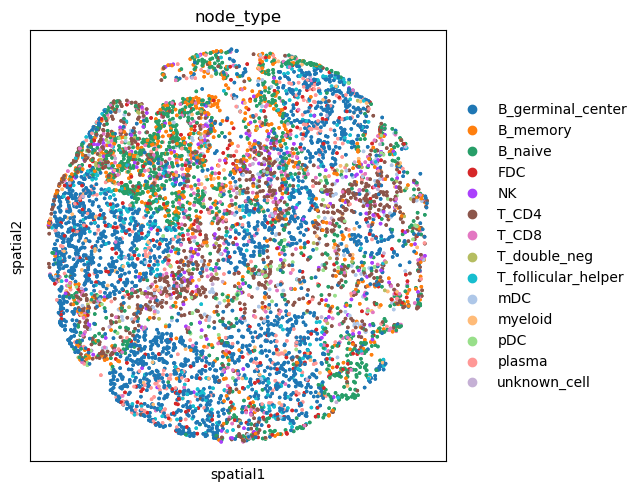

In [148]:
sq.pl.spatial_scatter(ad_orig_new_rc, color="node_type", size=10, shape=None)

## Spatial analysis

All/most spatial analyses requires the prior generation of spatial neighborhoods.

In [28]:
sq.gr.spatial_neighbors(ad_orig_gt, coord_type="generic", spatial_key = 'spatial')

In [29]:
sq.gr.spatial_neighbors(ad_orig_rc, coord_type="generic", spatial_key = 'spatial')

In [30]:
sq.gr.spatial_neighbors(ad_new_rc, coord_type="generic", spatial_key = 'spatial')

In [304]:
sq.gr.spatial_neighbors(ad_orig_rc_morph, coord_type="generic", spatial_key = 'spatial')

In [149]:
sq.gr.spatial_neighbors(ad_orig_new_rc, coord_type="generic", spatial_key = 'spatial')

### Neighborhood enrichment analysis

Performing neighborhood enrichment analysis using the cell type labels.

**Original, ground-truth**

In [32]:
ad_orig_gt.obs

orig.ident  nCount_RNA  nFeature_RNA             barcode  \
AAACCCAAGCGCCTTG-1           0      2403.0          1480  AAACCCAAGCGCCTTG-1   
AAACCCAAGTGGACGT-1           0      6435.0          3252  AAACCCAAGTGGACGT-1   
AAACCCACAGAAGTGC-1           0     11403.0          4801  AAACCCACAGAAGTGC-1   
AAACCCAGTCATTGCA-1           0      4946.0          2691  AAACCCAGTCATTGCA-1   
AAACCCATCATCGCAA-1           0       965.0           714  AAACCCATCATCGCAA-1   
...                        ...         ...           ...                 ...   
TTTGTTGCAGGGACTA-1           0      8680.0          3642  TTTGTTGCAGGGACTA-1   
TTTGTTGCATTGTAGC-1           0      5164.0          2553  TTTGTTGCATTGTAGC-1   
TTTGTTGGTACCACGC-1           0      7300.0          3190  TTTGTTGGTACCACGC-1   
TTTGTTGGTCTGTCCT-1           0      1337.0           979  TTTGTTGGTCTGTCCT-1   
TTTGTTGTCATGCGGC-1           0      1266.0           946  TTTGTTGTCATGCGGC-1   

                      UMAP_1    UMAP_2          cell_type    spatial_x  \
AAACCCAAGCGCCTTG-1 -0.000162  5.448931              T_CD4  1733.213235   
AAACCCAAGTGGACGT-1  6.108639 -3.613436             plasma   519.377858   
AAACCCACAGAAGTGC-1  3.004497 -4.724403  B_germinal_center  1064.296595   
AAACCCAGTCATTGCA-1 -2.515251 -0.117800            B_naive  1740.127314   
AAACCCATCATCGCAA-1 -6.681471  2.266072           B_memory   930.600158   
...                      ...       ...                ...          ...   
TTTGTTGCAGGGACTA-1  0.797100 -7.215735  B_germinal_center  1699.607471   
TTTGTTGCATTGTAGC-1  6.379490 -2.634052             plasma   688.211974   
TTTGTTGGTACCACGC-1  0.280147 -7.467218  B_germinal_center  1258.258885   
TTTGTTGGTCTGTCCT-1 -0.547337  6.427512              T_CD4  1833.578543   
TTTGTTGTCATGCGGC-1 -0.948239  6.841839              T_CD4  1056.736769   

                      spatial_y          node_type  type_prediction_score  \
AAACCCAAGCGCCTTG-1  1665.039824              T_CD4                   -1.0   
AAACCCAAGTGGACGT-1  2220.266321             plasma                   -1.0   
AAACCCACAGAAGTGC-1  2158.266703  B_germinal_center                   -1.0   
AAACCCAGTCATTGCA-1  3218.472808            B_naive                   -1.0   
AAACCCATCATCGCAA-1  2892.947737           B_memory                   -1.0   
...                         ...                ...                    ...   
TTTGTTGCAGGGACTA-1  1920.402412  B_germinal_center                   -1.0   
TTTGTTGCATTGTAGC-1  2794.005768             plasma                   -1.0   
TTTGTTGGTACCACGC-1  2713.702000  B_germinal_center                   -1.0   
TTTGTTGGTCTGTCCT-1  2142.848257              T_CD4                   -1.0   
TTTGTTGTCATGCGGC-1  2472.335923              T_CD4                   -1.0   

                    RNA_snn_res.0.75  seurat_clusters  seurat_clusters_mod  \
AAACCCAAGCGCCTTG-1                 3                3                  4.0   
AAACCCAAGTGGACGT-1                 9                9                 10.0   
AAACCCACAGAAGTGC-1                 2                2                 19.0   
AAACCCAGTCATTGCA-1                 0                0                  1.0   
AAACCCATCATCGCAA-1                 0                0                  1.0   
...                              ...              ...                  ...   
TTTGTTGCAGGGACTA-1                 2                2                 19.0   
TTTGTTGCATTGTAGC-1                 9                9                 10.0   
TTTGTTGGTACCACGC-1                 2                2                 19.0   
TTTGTTGGTCTGTCCT-1                 3                3                  4.0   
TTTGTTGTCATGCGGC-1                 3                3                  4.0   

                    percent.mt  
AAACCCAAGCGCCTTG-1    0.208073  
AAACCCAAGTGGACGT-1    0.186480  
AAACCCACAGAAGTGC-1    1.482066  
AAACCCAGTCATTGCA-1    1.273757  
AAACCCATCATCGCAA-1    0.207254  
...                        ...  
TTTGTTGCAGGGACTA-1    0.380184  
TTTGTTGCATTGTAGC-1    1.181255  
TTTGTTGGTAC

In [33]:
sq.gr.nhood_enrichment(ad_orig_gt, cluster_key="node_type")

  0%|          | 0/1000 [00:00<?, ?/s]

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


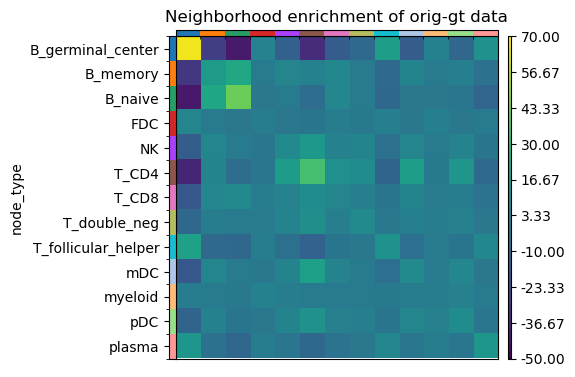

In [34]:
sq.pl.nhood_enrichment(
    ad_orig_gt, 
    cluster_key="node_type", 
    #method="single", 
    mode="zscore", 
    cmap="viridis", 
    figsize=[3.5,3.5],
    vmin=-50, vmax=70,
    title = "Neighborhood enrichment of orig-gt data",
    save=res_out_path+'nhood_orig_gt_hmap.pdf'
)

**Original, reconstructed**

In [35]:
ad_orig_rc.obsm['spatial']

array([[1743.47296342, 1787.34759783],
       [ 348.56320726, 2101.91817152],
       [1117.47435459, 2185.79902142],
       ...,
       [1331.70902613, 2630.06886444],
       [1878.37865172, 2227.94792527],
       [1123.99947162, 2397.15210888]])

In [36]:
#ad_orig_rc.obsm['spatial'][np.isnan(ad_orig_rc.obsm['spatial'])] = 0

In [37]:
sq.gr.nhood_enrichment(ad_orig_rc, cluster_key="node_type")

  0%|          | 0/1000 [00:00<?, ?/s]

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


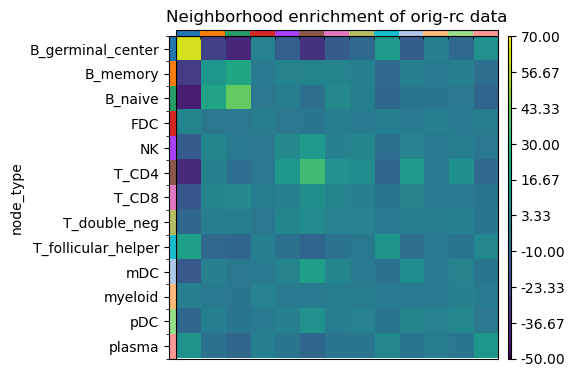

In [38]:
sq.pl.nhood_enrichment(
    ad_orig_rc, 
    cluster_key="node_type", 
    #method="single", 
    mode="zscore", 
    cmap="viridis", 
    figsize=[3.5,3.5],
    vmin=-50, vmax=70,
    title = "Neighborhood enrichment of orig-rc data",
    save=res_out_path+'nhood_orig_rc_hmap.pdf'
)

**New, reconstructed**

In [39]:
sq.gr.nhood_enrichment(ad_new_rc, cluster_key="node_type")

  0%|          | 0/1000 [00:00<?, ?/s]

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


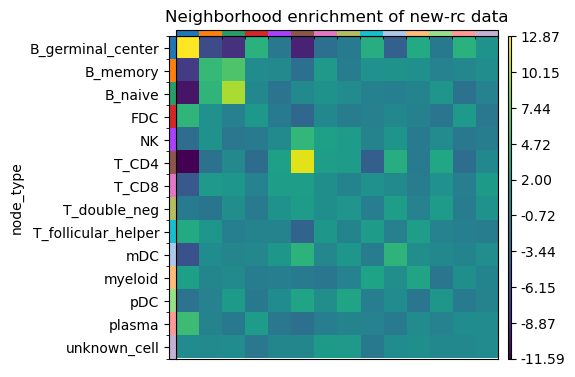

In [40]:
sq.pl.nhood_enrichment(
    ad_new_rc, 
    cluster_key="node_type", 
    #method="single", 
    mode="zscore", 
    cmap="viridis", 
    figsize=[3.5,3.5],
    #vmin=-20, vmax=30,
    title = "Neighborhood enrichment of new-rc data",
    save=res_out_path+'nhood_new_rc_hmap.pdf'
)

**Original, reconstructed, morphed**

In [305]:
ad_orig_rc_morph.obsm['spatial']

array([[2512.11589887, 2729.69471126],
       [ 614.34885524, 3290.02465107],
       [1059.51166444, 2494.71833082],
       ...,
       [2492.00235826, 4081.70599205],
       [2327.29307792, 3105.00633432],
       [1310.55004213, 4888.67141429]])

In [306]:
sq.gr.nhood_enrichment(ad_orig_rc_morph, cluster_key="node_type")

  0%|          | 0/1000 [00:00<?, ?/s]

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


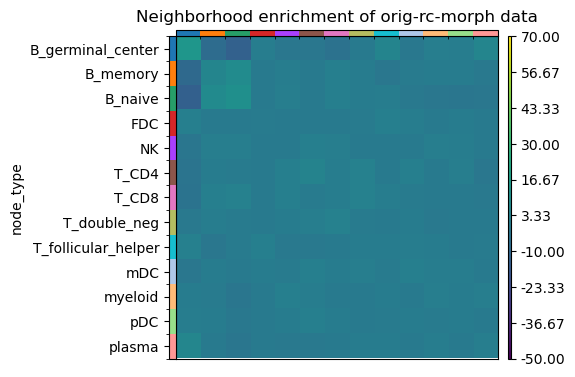

In [307]:
sq.pl.nhood_enrichment(
    ad_orig_rc_morph, 
    cluster_key="node_type", 
    #method="single", 
    mode="zscore", 
    cmap="viridis", 
    figsize=[3.5,3.5],
    vmin=-50, vmax=70,
    title = "Neighborhood enrichment of orig-rc-morph data",
    save=res_out_path+'nhood_orig_rc_hmap_morph.pdf'
)

**Original+new, reconstructed, morphed**

In [164]:
sq.gr.nhood_enrichment(ad_orig_new_rc, cluster_key="cell_type")

  0%|          | 0/1000 [00:00<?, ?/s]

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


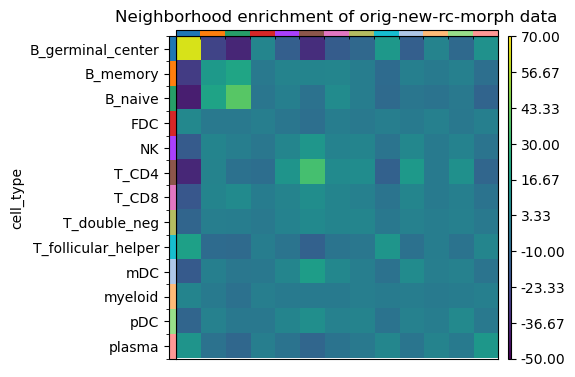

In [165]:
sq.pl.nhood_enrichment(
    ad_orig_new_rc, 
    cluster_key="cell_type", 
    #method="single", 
    mode="zscore", 
    cmap="viridis", 
    figsize=[3.5,3.5],
    vmin=-50, vmax=70,
    title = "Neighborhood enrichment of orig-new-rc-morph data",
    save=res_out_path+'nhood_orig_new_rc_hmap_morph.pdf'
)

**Export resulting data**

In [44]:
# ad_orig_gt.uns['node_type']

In [45]:
cells = ad_orig_gt.obs['node_type'].unique().tolist()
(cells)

['T_CD4',
 'plasma',
 'B_germinal_center',
 'B_naive',
 'B_memory',
 'mDC',
 'T_follicular_helper',
 'NK',
 'FDC',
 'T_CD8',
 'pDC',
 'myeloid',
 'T_double_neg']

In [158]:
ad_orig_gt.uns['node_type_nhood_enrichment']['zscore'][0:5,0:4]

array([[ 67.34075593, -27.70275039, -41.26348155,   3.18436893],
       [-30.35236654,  15.54086051,  21.3702126 ,  -0.1706993 ],
       [-41.93231924,  20.73666661,  43.16111709,  -2.61316172],
       [  4.83626963,  -0.15640763,  -2.38311783,   0.35920754],
       [-14.71244994,   5.08775526,  -1.24959946,  -3.03909773]])

In [157]:
ad_orig_rc.uns['node_type_nhood_enrichment']['zscore'][0:5,0:4]

array([[ 64.47181653, -25.95283083, -37.83854654,   3.31569592],
       [-29.27939543,  14.20120111,  21.47878328,  -1.63038846],
       [-39.0885471 ,  18.9526498 ,  41.16771533,  -2.0593909 ],
       [  3.5510374 ,  -1.96971699,  -1.92099922,   0.45481256],
       [-14.98794305,   5.39396671,  -0.11947267,  -2.19239638]])

In [308]:
ad_orig_rc_morph.uns['node_type_nhood_enrichment']['zscore'][0:5,0:4]

array([[ 12.9058827 ,  -7.78620439, -12.70747993,   0.62855401],
       [ -8.77033615,   4.54252087,   7.712366  ,  -0.52257038],
       [-13.0632064 ,   7.428646  ,   9.93136442,  -0.41558163],
       [  1.56633028,  -1.21239341,  -0.32111798,   0.08895534],
       [ -3.08492301,   1.27762617,   1.51137323,  -0.99623252]])

In [309]:
ad_orig_rc.uns['node_type_nhood_enrichment']['zscore'] - ad_orig_rc_morph.uns['node_type_nhood_enrichment']['zscore']

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Seems like the rc and rc-morph results are identical??

In [167]:
ad_orig_rc.uns['node_type_nhood_enrichment']['zscore'] - ad_orig_new_rc.uns['cell_type_nhood_enrichment']['zscore']

array([[ 1.9353244 , -0.65203967, -0.73131494, -1.32673522, -0.41258995,
         1.78499198, -0.71051183,  1.17778239, -0.43559134, -0.53584145,
        -1.23767806,  0.6652497 , -0.0749242 ],
       [-0.44064798, -0.89544432,  0.86748188, -0.22320365,  0.66400417,
        -0.37636169,  0.58247827,  0.33946743, -0.22333686,  0.25745411,
         0.19438318,  0.58756602, -0.10760131],
       [ 0.72688117, -0.65741691,  2.53244481,  0.72709218, -1.65790189,
        -1.07858225, -1.26238141,  0.11417251, -1.03867699, -0.37345639,
         0.88400324, -1.94998779,  0.18922784],
       [-2.29940306, -0.71223241, -0.25127832, -0.9051922 ,  0.03349787,
         3.12000186,  0.39434275, -0.14265996,  0.70266195, -0.64068134,
         1.11069413,  1.73452648, -0.42428275],
       [ 0.72125235,  1.21998189, -1.44554121,  0.13053706,  2.50604042,
         1.1917411 , -1.0672487 ,  0.03438116, -1.06993613, -1.65218244,
         0.65280874, -1.78267294,  1.40477024],
       [ 1.69618796, -0.859788

Export as text files

In [169]:
np.array(cells)

array(['T_CD4', 'plasma', 'B_germinal_center', 'B_naive', 'B_memory',
       'mDC', 'T_follicular_helper', 'NK', 'FDC', 'T_CD8', 'pDC',
       'myeloid', 'T_double_neg'], dtype='<U19')

In [209]:
np.savetxt(res_out_path+'nhood_cells.csv', 
           np.array(cells), delimiter=',', fmt='%s')

In [211]:
nhood_orig_gt = ad_orig_gt.uns['node_type_nhood_enrichment']['zscore']
np.savetxt(res_out_path+'nhood_stats_orig_gt.csv', nhood_orig_gt, delimiter=',')

In [212]:
nhood_orig_rc = ad_orig_rc.uns['node_type_nhood_enrichment']['zscore']
np.savetxt(res_out_path+'nhood_stats_orig_rc.csv', nhood_orig_rc, delimiter=',')

In [213]:
nhood_new_rc = ad_new_rc.uns['node_type_nhood_enrichment']['zscore']
np.savetxt(res_out_path+'nhood_stats_new_rc.csv', nhood_new_rc, delimiter=',')

In [214]:
nhood_orig_rc_morph = ad_orig_rc_morph.uns['node_type_nhood_enrichment']['zscore']
np.savetxt(res_out_path+'nhood_stats_orig_rc_morph.csv', 
           nhood_orig_rc_morph, delimiter=',')

In [215]:
nhood_orig_new_rc = ad_orig_new_rc.uns['cell_type_nhood_enrichment']['zscore']
np.savetxt(res_out_path+'nhood_stats_orig_new_rc.csv', 
           nhood_orig_new_rc, delimiter=',')

### Ripley’s statistics

**orig-gt data**

In [55]:
mode = "L"
sq.gr.ripley(ad_orig_gt, cluster_key="node_type", mode=mode, max_dist=2000)

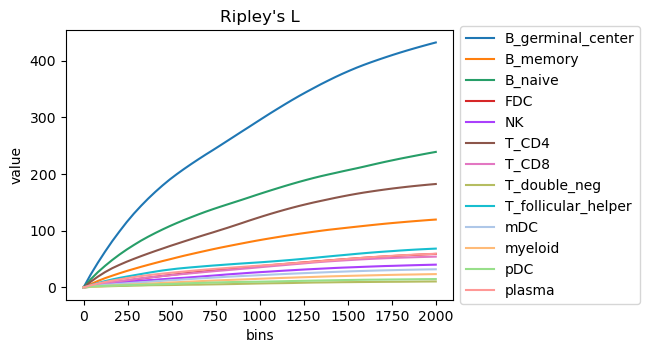

In [171]:
sq.pl.ripley(ad_orig_gt, cluster_key="node_type", mode=mode, 
             figsize=[5,3.5],
             plot_sims=False,
             save=res_out_path+'ripley_orig_gt_plot.pdf')

**orig-rc data**

In [172]:
mode = "L"
sq.gr.ripley(ad_orig_rc, cluster_key="node_type", mode=mode, max_dist=2000)

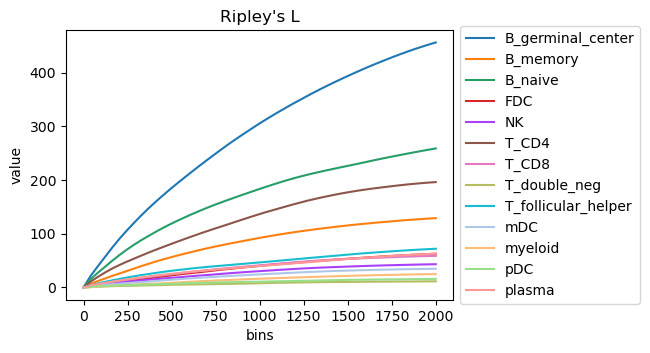

In [174]:
sq.pl.ripley(ad_orig_rc, cluster_key="node_type", mode=mode, 
             figsize=[5,3.5],
             plot_sims=False,
             save=res_out_path+'ripley_orig_rc_plot.pdf')

**new-rc data**

In [59]:
mode = "L"
sq.gr.ripley(ad_new_rc, cluster_key="node_type", mode=mode, max_dist=2000)

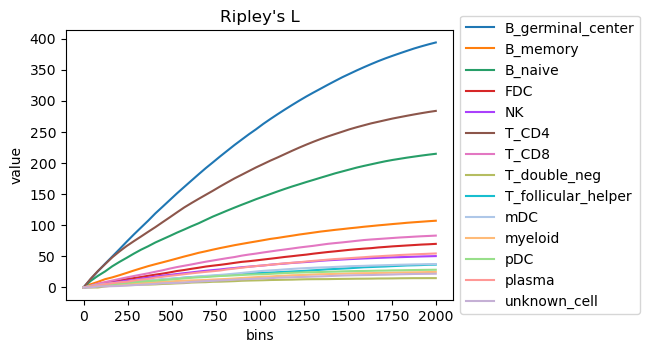

In [175]:
sq.pl.ripley(ad_new_rc, cluster_key="node_type", mode=mode,
             figsize=[5,3.5],
             plot_sims=False,
             save=res_out_path+'ripley_new_rc_plot.pdf')

**orig-rc-morph data**

In [61]:
mode = "L"
sq.gr.ripley(ad_orig_rc_morph, cluster_key="node_type", mode=mode, max_dist=2000)

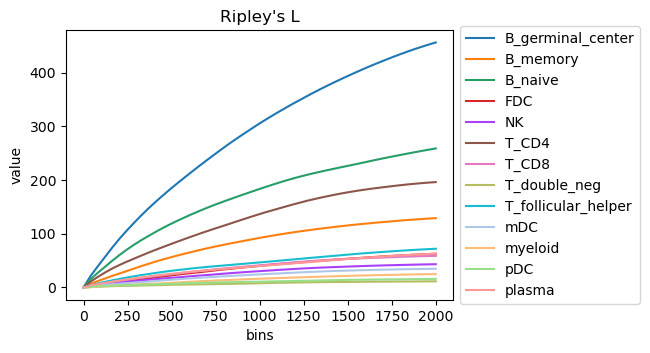

In [176]:
sq.pl.ripley(ad_orig_rc_morph, cluster_key="node_type", mode=mode,
             figsize=[5,3.5],
             plot_sims=False,
             save=res_out_path+'ripley_orig_rc_morph_plot.pdf')

**orig-new-rc-morph data**

In [179]:
mode = "L"
sq.gr.ripley(ad_orig_new_rc, cluster_key="node_type", mode=mode, max_dist=2000)

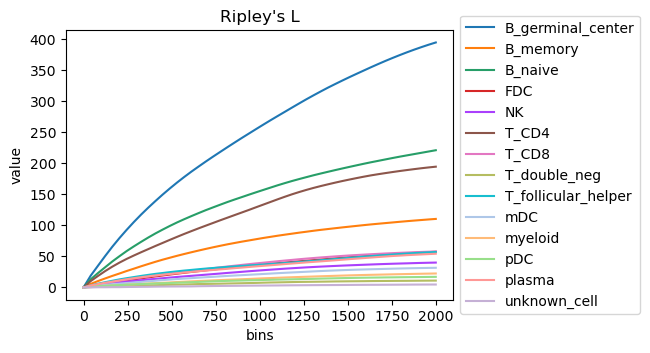

In [180]:
sq.pl.ripley(ad_orig_new_rc, cluster_key="node_type", mode=mode,
             figsize=[5,3.5],
             plot_sims=False,
             save=res_out_path+'ripley_orig_new_rc_plot.pdf')

**Export results**

In [181]:
ripley_orig_gt = ad_orig_gt.uns['node_type_ripley_L']['L_stat']
ripley_orig_gt['group'] = 'orig_gt'
ripley_orig_gt

bins          node_type      stats    group
0       0.000000  B_germinal_center   0.000000  orig_gt
1      40.816327  B_germinal_center  22.886232  orig_gt
2      81.632653  B_germinal_center  43.759972  orig_gt
3     122.448980  B_germinal_center  63.286993  orig_gt
4     163.265306  B_germinal_center  81.755383  orig_gt
..           ...                ...        ...      ...
645  1836.734694             plasma  57.241420  orig_gt
646  1877.551020             plasma  57.881702  orig_gt
647  1918.367347             plasma  58.426044  orig_gt
648  1959.183673             plasma  58.949926  orig_gt
649  2000.000000             plasma  59.477936  orig_gt

[650 rows x 4 columns]

In [182]:
ripley_orig_gt.to_csv(res_out_path+'ripley_stats_orig_gt.csv')

In [183]:
ripley_orig_rc = ad_orig_rc.uns['node_type_ripley_L']['L_stat']
ripley_orig_rc['group'] = 'orig_rc'
ripley_orig_rc

bins          node_type      stats    group
0       0.000000  B_germinal_center   0.000000  orig_rc
1      40.816327  B_germinal_center  21.703484  orig_rc
2      81.632653  B_germinal_center  39.680249  orig_rc
3     122.448980  B_germinal_center  57.042397  orig_rc
4     163.265306  B_germinal_center  74.390579  orig_rc
..           ...                ...        ...      ...
645  1836.734694             plasma  60.284943  orig_rc
646  1877.551020             plasma  60.995428  orig_rc
647  1918.367347             plasma  61.688149  orig_rc
648  1959.183673             plasma  62.335251  orig_rc
649  2000.000000             plasma  62.902907  orig_rc

[650 rows x 4 columns]

In [184]:
ripley_orig_rc.to_csv(res_out_path+'ripley_stats_orig_rc.csv')

In [185]:
ripley_new_rc = ad_new_rc.uns['node_type_ripley_L']['L_stat']
ripley_new_rc['group'] = 'new_rc'
ripley_new_rc

bins          node_type      stats   group
0       0.000000  B_germinal_center   0.000000  new_rc
1      40.816327  B_germinal_center  13.321642  new_rc
2      81.632653  B_germinal_center  26.063714  new_rc
3     122.448980  B_germinal_center  38.082498  new_rc
4     163.265306  B_germinal_center  49.742775  new_rc
..           ...                ...        ...     ...
695  1836.734694       unknown_cell  21.439833  new_rc
696  1877.551020       unknown_cell  21.709527  new_rc
697  1918.367347       unknown_cell  21.809802  new_rc
698  1959.183673       unknown_cell  21.942790  new_rc
699  2000.000000       unknown_cell  22.107900  new_rc

[700 rows x 4 columns]

In [186]:
ripley_new_rc.to_csv(res_out_path+'ripley_stats_new_rc.csv')

In [187]:
ripley_orig_rc_morph = ad_orig_rc_morph.uns['node_type_ripley_L']['L_stat']
ripley_orig_rc_morph['group'] = 'orig_rc_morph'
ripley_orig_rc_morph

bins          node_type      stats          group
0       0.000000  B_germinal_center   0.000000  orig_rc_morph
1      40.816327  B_germinal_center  21.703484  orig_rc_morph
2      81.632653  B_germinal_center  39.680249  orig_rc_morph
3     122.448980  B_germinal_center  57.042397  orig_rc_morph
4     163.265306  B_germinal_center  74.390579  orig_rc_morph
..           ...                ...        ...            ...
645  1836.734694             plasma  60.284943  orig_rc_morph
646  1877.551020             plasma  60.995428  orig_rc_morph
647  1918.367347             plasma  61.688149  orig_rc_morph
648  1959.183673             plasma  62.335251  orig_rc_morph
649  2000.000000             plasma  62.902907  orig_rc_morph

[650 rows x 4 columns]

In [188]:
ripley_orig_rc_morph.to_csv(res_out_path+'ripley_stats_orig_rc_morph.csv')

In [189]:
ripley_orig_new_rc = ad_orig_new_rc.uns['node_type_ripley_L']['L_stat']
ripley_orig_new_rc['group'] = 'orig_new_rc_morph'
ripley_orig_new_rc

bins          node_type      stats              group
0       0.000000  B_germinal_center   0.000000  orig_new_rc_morph
1      40.816327  B_germinal_center  19.056903  orig_new_rc_morph
2      81.632653  B_germinal_center  34.838889  orig_new_rc_morph
3     122.448980  B_germinal_center  50.533001  orig_new_rc_morph
4     163.265306  B_germinal_center  65.580419  orig_new_rc_morph
..           ...                ...        ...                ...
695  1836.734694       unknown_cell   4.569313  orig_new_rc_morph
696  1877.551020       unknown_cell   4.665054  orig_new_rc_morph
697  1918.367347       unknown_cell   4.701359  orig_new_rc_morph
698  1959.183673       unknown_cell   4.744557  orig_new_rc_morph
699  2000.000000       unknown_cell   4.758870  orig_new_rc_morph

[700 rows x 4 columns]

In [191]:
ripley_orig_new_rc.to_csv(res_out_path+'ripley_stats_orig_new_rc.csv')

### Interaction matrix

Similar to neighborhood enrichment analysis.

https://www.sc-best-practices.org/spatial/neighborhood.html

In [71]:
sq.gr.interaction_matrix(ad_orig_gt, cluster_key="node_type")

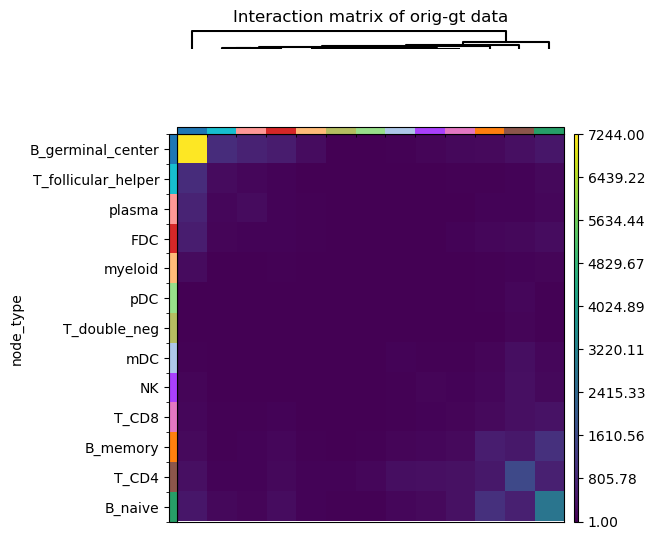

In [72]:
sq.pl.interaction_matrix(ad_orig_gt, cluster_key="node_type", method="average", figsize=(5, 5),
                         title = "Interaction matrix of orig-gt data",
                         save = res_out_path+'interaction_orig_gt_hmap.pdf')

In [73]:
sq.gr.interaction_matrix(ad_orig_rc, cluster_key="node_type")

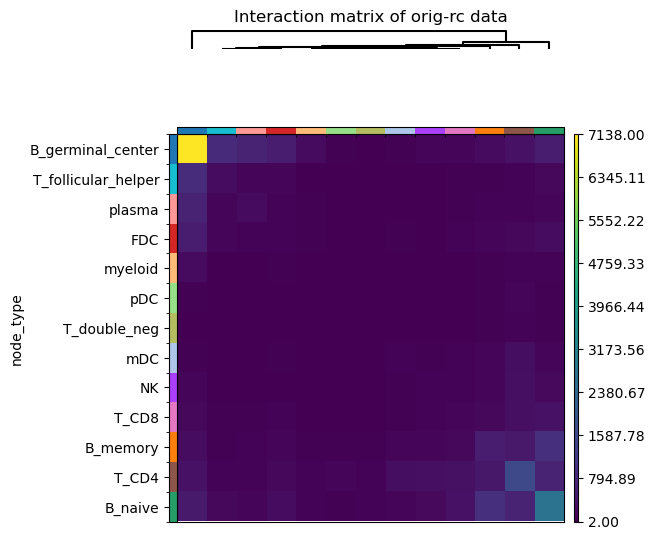

In [74]:
sq.pl.interaction_matrix(ad_orig_rc, cluster_key="node_type", method="average", figsize=(5, 5),
                        title = "Interaction matrix of orig-rc data",
                        save = res_out_path+'interaction_orig_rc_hmap.pdf')

In [75]:
sq.gr.interaction_matrix(ad_new_rc, cluster_key="node_type")

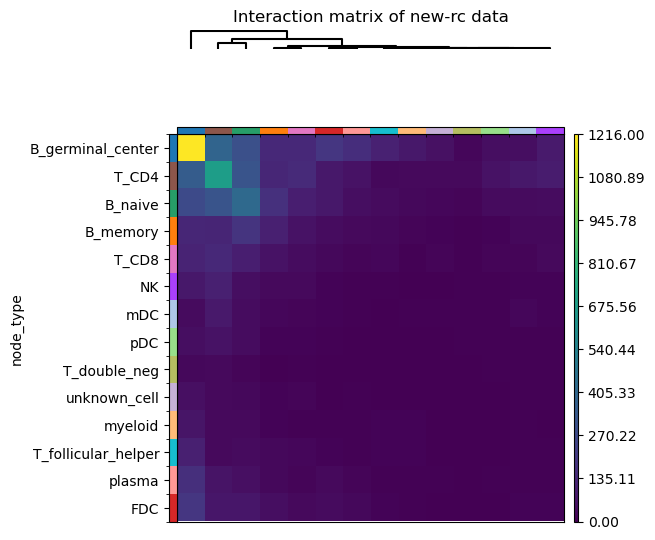

In [76]:
sq.pl.interaction_matrix(ad_new_rc, cluster_key="node_type", method="average", figsize=(5, 5),
                        title = "Interaction matrix of new-rc data",
                        save = res_out_path+'interaction_new_rc_hmap.pdf')

In [77]:
sq.gr.interaction_matrix(ad_orig_rc_morph, cluster_key="node_type")

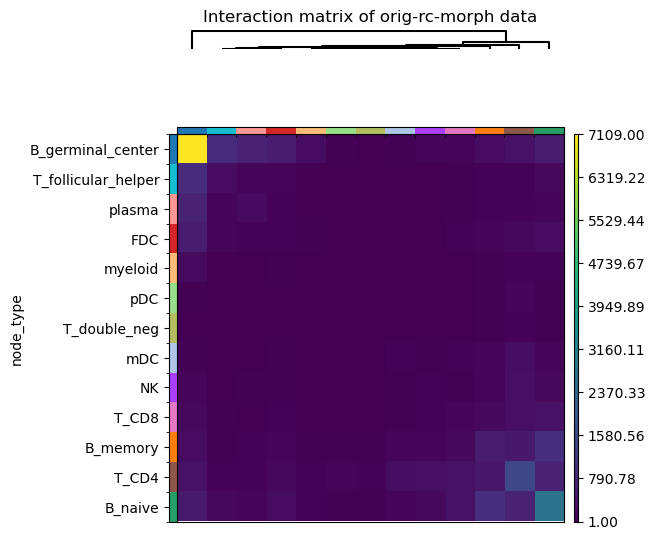

In [78]:
sq.pl.interaction_matrix(ad_orig_rc_morph, cluster_key="node_type", method="average", figsize=(5, 5),
                        title = "Interaction matrix of orig-rc-morph data",
                        save = res_out_path+'interaction_orig_rc_morph_hmap.pdf')

### Co-occurrence across spatial dimensions

Computing co-occurrence for cell types.

**Original, ground-truth**

In [79]:
sq.gr.co_occurrence(ad_orig_gt, cluster_key="node_type")

  0%|          | 0/1 [00:00<?, ?/s]

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


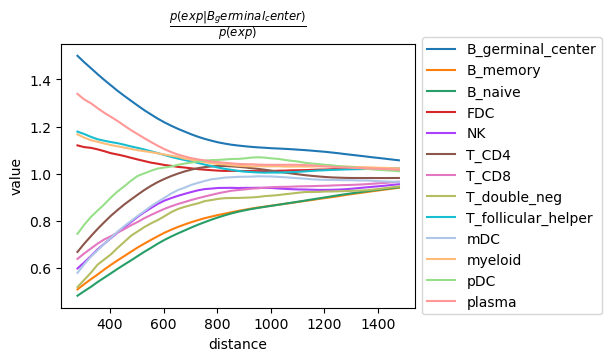

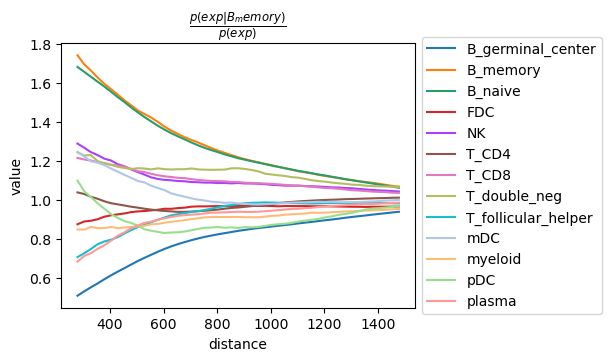

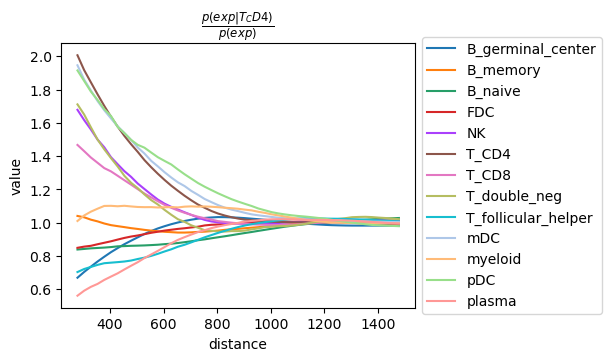

In [80]:
sq.pl.co_occurrence(ad_orig_gt, cluster_key="node_type", clusters="B_germinal_center", figsize=(6, 3.5),
                   save=res_out_path+'cooccurrence_orig_gt_Bgc.pdf')
sq.pl.co_occurrence(ad_orig_gt, cluster_key="node_type", clusters="B_memory", figsize=(6, 3.5),
                   save=res_out_path+'cooccurrence_orig_gt_Bmem.pdf')
sq.pl.co_occurrence(ad_orig_gt, cluster_key="node_type", clusters="T_CD4", figsize=(6, 3.5),
                   save=res_out_path+'cooccurrence_orig_gt_Tcd4.pdf')

**Original, recon**

In [81]:
sq.gr.co_occurrence(ad_orig_rc, cluster_key="node_type")

  0%|          | 0/1 [00:00<?, ?/s]

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


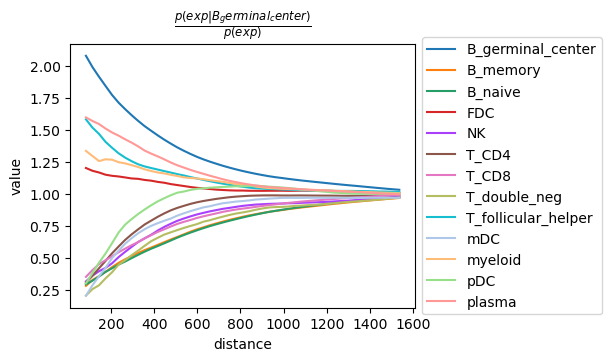

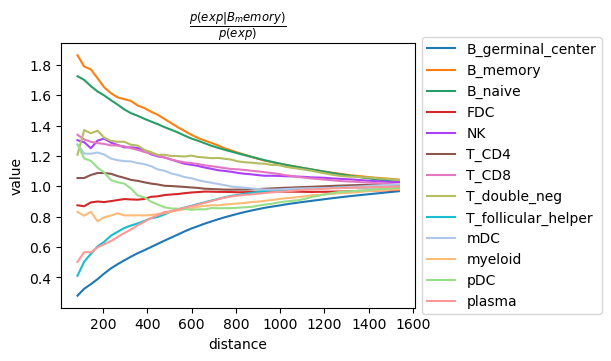

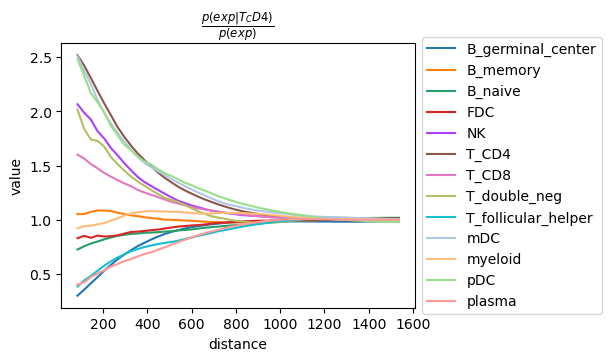

In [82]:
sq.pl.co_occurrence(ad_orig_rc, cluster_key="node_type", clusters="B_germinal_center", figsize=(6, 3.5),
                   save=res_out_path+'cooccurrence_orig_rc_Bgc.pdf')
sq.pl.co_occurrence(ad_orig_rc, cluster_key="node_type", clusters="B_memory", figsize=(6, 3.5),
                   save=res_out_path+'cooccurrence_orig_rc_Bmem.pdf')
sq.pl.co_occurrence(ad_orig_rc, cluster_key="node_type", clusters="T_CD4", figsize=(6, 3.5),
                   save=res_out_path+'cooccurrence_orig_rc_Tcd4.pdf')

**New cell, recon**

In [83]:
sq.gr.co_occurrence(ad_new_rc, cluster_key="node_type")

  0%|          | 0/1 [00:00<?, ?/s]

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


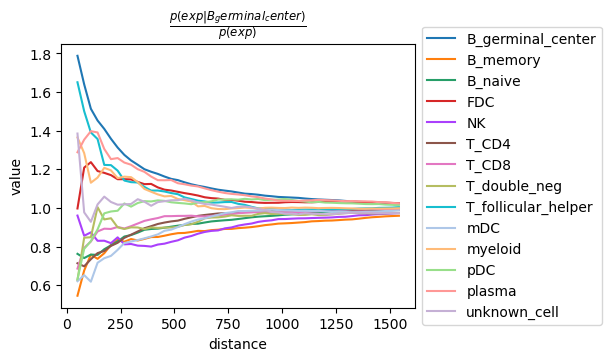

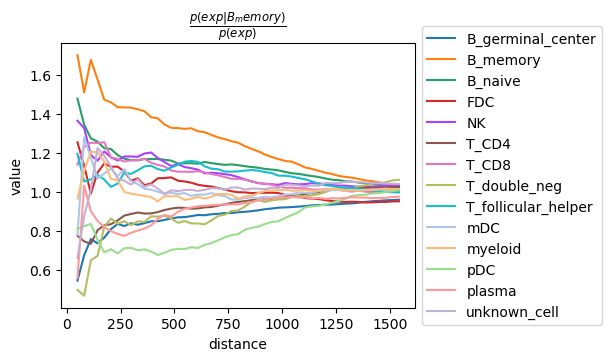

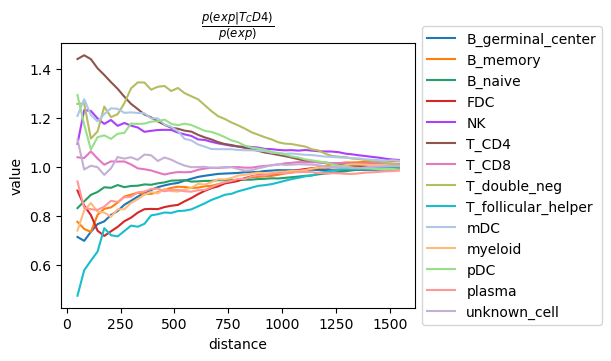

In [84]:
sq.pl.co_occurrence(ad_new_rc, cluster_key="node_type", clusters="B_germinal_center", figsize=(6, 3.5))
sq.pl.co_occurrence(ad_new_rc, cluster_key="node_type", clusters="B_memory", figsize=(6, 3.5))
sq.pl.co_occurrence(ad_new_rc, cluster_key="node_type", clusters="T_CD4", figsize=(6, 3.5))

**Original, recon-morphed**

In [85]:
sq.gr.co_occurrence(ad_orig_rc_morph, cluster_key="node_type")

  0%|          | 0/1 [00:00<?, ?/s]

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


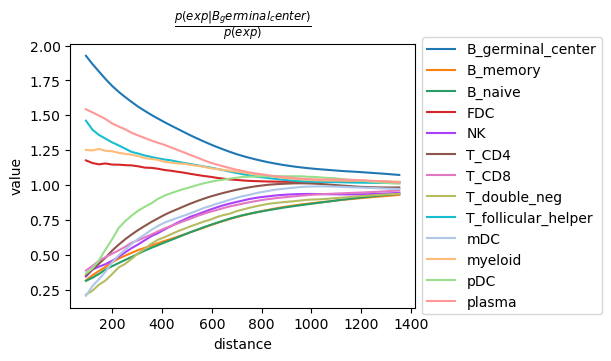

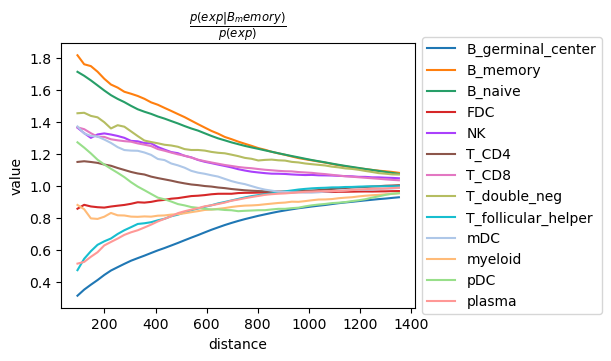

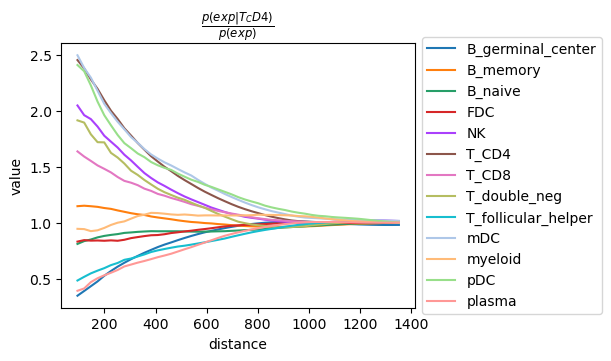

In [86]:
sq.pl.co_occurrence(ad_orig_rc_morph, cluster_key="node_type", clusters="B_germinal_center", figsize=(6, 3.5),
                   save=res_out_path+'cooccurrence_orig_rc_morph_Bgc.pdf')
sq.pl.co_occurrence(ad_orig_rc_morph, cluster_key="node_type", clusters="B_memory", figsize=(6, 3.5),
                   save=res_out_path+'cooccurrence_orig_rc_morph_Bmem.pdf')
sq.pl.co_occurrence(ad_orig_rc_morph, cluster_key="node_type", clusters="T_CD4", figsize=(6, 3.5),
                   save=res_out_path+'cooccurrence_orig_rc_morph_Tcd4.pdf')

In [194]:
sq.gr.co_occurrence(ad_orig_new_rc, cluster_key="cell_type")

  0%|          | 0/1 [00:00<?, ?/s]

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


ERROR: Unable to fetch palette, reason: 'cell_type_colors'. Using `None`.
ERROR: Unable to fetch palette, reason: 'cell_type_colors'. Using `None`.
ERROR: Unable to fetch palette, reason: 'cell_type_colors'. Using `None`.


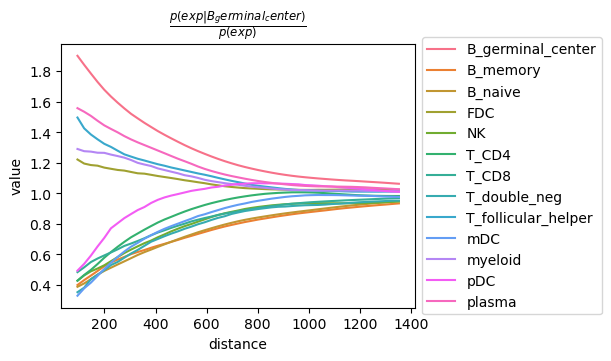

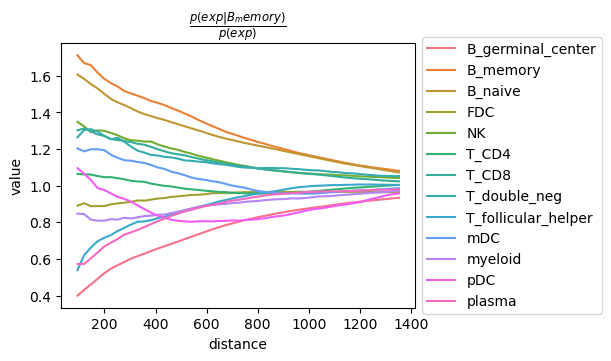

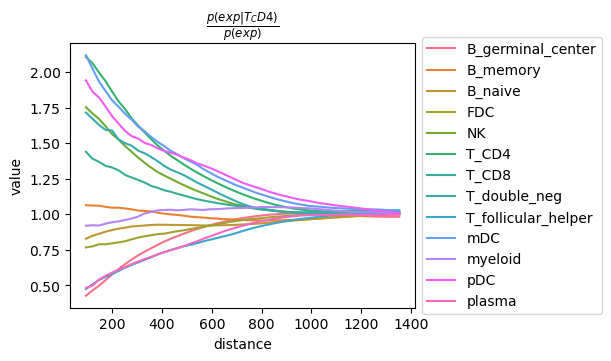

In [197]:
sq.pl.co_occurrence(ad_orig_new_rc, cluster_key="cell_type", clusters="B_germinal_center", figsize=(6, 3.5),
                   save=res_out_path+'cooccurrence_orig_rc_morph_Bgc.pdf')
sq.pl.co_occurrence(ad_orig_new_rc, cluster_key="cell_type", clusters="B_memory", figsize=(6, 3.5),
                   save=res_out_path+'cooccurrence_orig_rc_morph_Bmem.pdf')
sq.pl.co_occurrence(ad_orig_new_rc, cluster_key="cell_type", clusters="T_CD4", figsize=(6, 3.5),
                   save=res_out_path+'cooccurrence_orig_rc_morph_Tcd4.pdf')

Export results as tables

In [263]:
def export_occ_res(adata, cluster_key, fname):
    occurrence_data = adata.uns[cluster_key+'_co_occurrence']
    out = occurrence_data["occ"]
    interval = occurrence_data["interval"][1:]
    categories = adata.obs[cluster_key].cat.categories

    appended_data = []
    for g in categories:
        idx = np.where(categories == g)[0][0]
        df = pd.DataFrame(out[idx, :, :].T, columns=categories).melt(var_name=cluster_key, value_name="probability")
        df["distance"] = np.tile(interval, len(categories))
        df['origin'] = g
        appended_data.append(df)

    out_df = pd.concat(appended_data)

    out_df.to_csv(fname, index=False)

In [264]:
export_occ_res(adata=ad_orig_gt, cluster_key='node_type', fname=(res_out_path+'co_occurrence_stats_orig_gt.csv'))

In [265]:
export_occ_res(adata=ad_orig_rc, cluster_key='node_type', fname=(res_out_path+'co_occurrence_stats_orig_rc.csv'))

In [266]:
export_occ_res(adata=ad_new_rc, cluster_key='node_type', fname=(res_out_path+'co_occurrence_stats_new_rc.csv'))

In [267]:
export_occ_res(adata=ad_orig_rc_morph, cluster_key='node_type', fname=(res_out_path+'co_occurrence_stats_orig_rc_morph.csv'))

In [269]:
export_occ_res(adata=ad_orig_new_rc, cluster_key='cell_type', fname=(res_out_path+'co_occurrence_stats_orig_new_rc.csv'))

### Spatially variable genes – Moran's I

https://www.sc-best-practices.org/spatial/spatially_variable_genes.html#

In [87]:
sq.gr.spatial_autocorr(ad_orig_gt, mode="moran", genes=ad_orig_gt.var_names)

In [88]:
ad_orig_gt.uns["moranI"].head(n=15)

I  pval_norm  var_norm  pval_norm_fdr_bh
AC090125.1  0.537905        0.0  0.000053               0.0
RANBP1      0.510379        0.0  0.000053               0.0
CCDC60      0.444180        0.0  0.000053               0.0
PRIMA1      0.425846        0.0  0.000053               0.0
AL132633.1  0.420543        0.0  0.000053               0.0
MMP9        0.399089        0.0  0.000053               0.0
LTBP2       0.389999        0.0  0.000053               0.0
CDON        0.383864        0.0  0.000053               0.0
DYNC1I1     0.381666        0.0  0.000053               0.0
KLF5        0.358367        0.0  0.000053               0.0
AC117377.1  0.332570        0.0  0.000053               0.0
SAMSN1      0.312137        0.0  0.000053               0.0
SLC14A1     0.295145        0.0  0.000053               0.0
AC021504.1  0.255529        0.0  0.000053               0.0
CBLN2       0.249784        0.0  0.000053               0.0

In [89]:
sq.gr.spatial_autocorr(ad_orig_rc, mode="moran", genes=ad_orig_rc.var_names)
ad_orig_rc.uns["moranI"].head(n=15)

I  pval_norm  var_norm  pval_norm_fdr_bh
AC090125.1  0.526234        0.0  0.000053               0.0
RANBP1      0.489492        0.0  0.000053               0.0
CCDC60      0.438423        0.0  0.000053               0.0
PRIMA1      0.417095        0.0  0.000053               0.0
AL132633.1  0.413061        0.0  0.000053               0.0
MMP9        0.383654        0.0  0.000053               0.0
DYNC1I1     0.381444        0.0  0.000053               0.0
LTBP2       0.376588        0.0  0.000053               0.0
CDON        0.370443        0.0  0.000053               0.0
KLF5        0.352175        0.0  0.000053               0.0
AC117377.1  0.334640        0.0  0.000053               0.0
SAMSN1      0.296533        0.0  0.000053               0.0
SLC14A1     0.287100        0.0  0.000053               0.0
SMIM41      0.247714        0.0  0.000053               0.0
AC021504.1  0.242292        0.0  0.000053               0.0

In [90]:
sq.gr.spatial_autocorr(ad_new_rc, mode="moran", genes=ad_new_rc.var_names)
ad_new_rc.uns["moranI"].head(n=15)

I  pval_norm  var_norm  pval_norm_fdr_bh
AC011287.2  0.364713        0.0  0.000168               0.0
AL137017.1  0.322723        0.0  0.000168               0.0
RBPMS       0.310012        0.0  0.000168               0.0
AC068413.1  0.301358        0.0  0.000168               0.0
CSMD1       0.287934        0.0  0.000168               0.0
EGFR        0.287041        0.0  0.000168               0.0
KANK1       0.282108        0.0  0.000168               0.0
SLCO2B1     0.278571        0.0  0.000168               0.0
TMEM178B    0.276363        0.0  0.000168               0.0
LINC01484   0.272620        0.0  0.000168               0.0
AC117480.1  0.267563        0.0  0.000168               0.0
AL162718.1  0.262281        0.0  0.000168               0.0
AC011586.2  0.249392        0.0  0.000168               0.0
RASGEF1A    0.237393        0.0  0.000168               0.0
PTN         0.231598        0.0  0.000168               0.0

In [91]:
sq.gr.spatial_autocorr(ad_orig_rc_morph, mode="moran", genes=ad_orig_rc_morph.var_names)
ad_orig_rc_morph.uns["moranI"].head(n=15)

I  pval_norm  var_norm  pval_norm_fdr_bh
AC090125.1  0.524169        0.0  0.000053               0.0
RANBP1      0.485037        0.0  0.000053               0.0
CCDC60      0.439786        0.0  0.000053               0.0
PRIMA1      0.414977        0.0  0.000053               0.0
AL132633.1  0.411699        0.0  0.000053               0.0
MMP9        0.380716        0.0  0.000053               0.0
DYNC1I1     0.380546        0.0  0.000053               0.0
LTBP2       0.375298        0.0  0.000053               0.0
CDON        0.366654        0.0  0.000053               0.0
KLF5        0.346017        0.0  0.000053               0.0
AC117377.1  0.331785        0.0  0.000053               0.0
SAMSN1      0.296011        0.0  0.000053               0.0
SLC14A1     0.284358        0.0  0.000053               0.0
AC021504.1  0.239282        0.0  0.000053               0.0
SMIM41      0.239252        0.0  0.000053               0.0

In [273]:
sq.gr.spatial_autocorr(ad_orig_new_rc, mode="moran", genes=ad_orig_new_rc.var_names)
ad_orig_new_rc.uns["moranI"].head(n=15)

I  pval_norm  var_norm  pval_norm_fdr_bh
AC011287.2  0.506003        0.0   0.00004               0.0
AL137017.1  0.467662        0.0   0.00004               0.0
KANK1       0.461579        0.0   0.00004               0.0
RBPMS       0.446584        0.0   0.00004               0.0
SLCO2B1     0.427163        0.0   0.00004               0.0
AC117480.1  0.414521        0.0   0.00004               0.0
AC068413.1  0.400494        0.0   0.00004               0.0
EGFR        0.398845        0.0   0.00004               0.0
AL162718.1  0.392073        0.0   0.00004               0.0
AC011586.2  0.388294        0.0   0.00004               0.0
S100B       0.387592        0.0   0.00004               0.0
CSMD1       0.372927        0.0   0.00004               0.0
TMEM178B    0.366075        0.0   0.00004               0.0
GLI3        0.362244        0.0   0.00004               0.0
LINC01484   0.356447        0.0   0.00004               0.0

Plot results

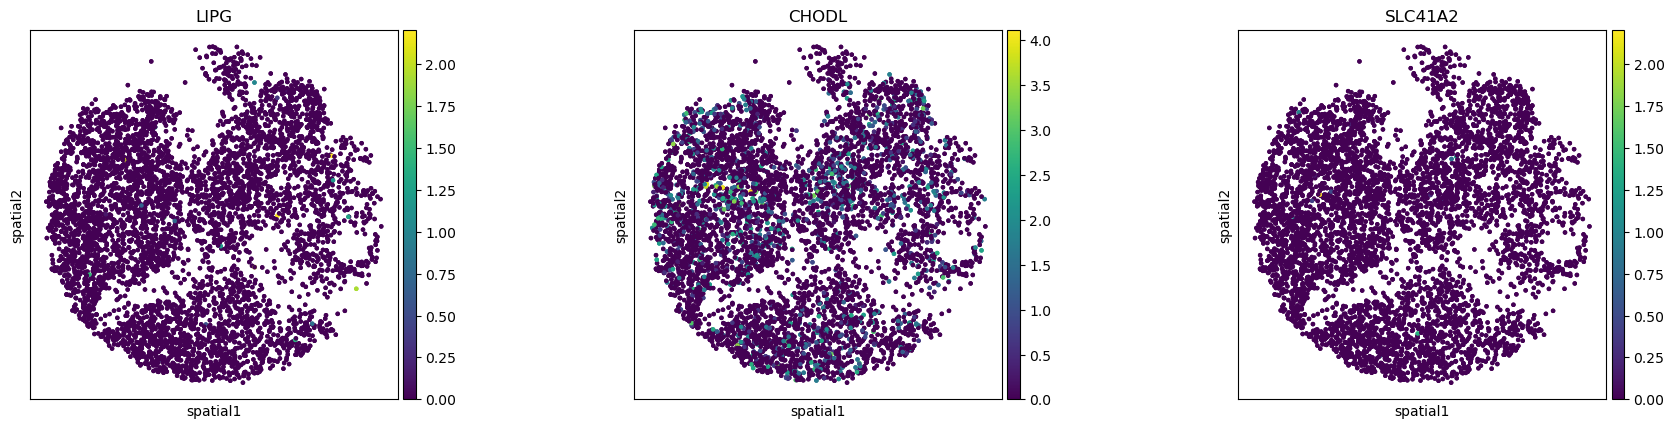

In [92]:
#sq.pl.spatial_scatter(ad_orig_gt, color=["RGS13", "AFF2", "LHFPL2"], size=10, shape=None)
sq.pl.spatial_scatter(ad_orig_gt, color=["LIPG", "CHODL", "SLC41A2"], size=20, shape=None)

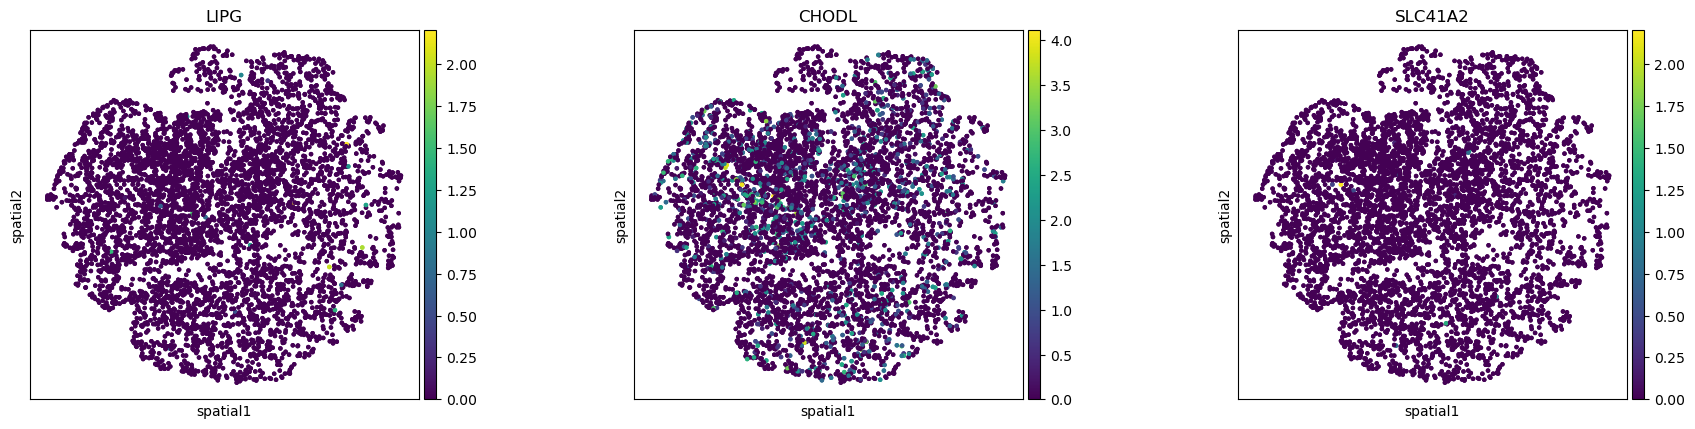

In [93]:
#sq.pl.spatial_scatter(ad_orig_rc, color=["RGS13", "AFF2", "LHFPL2"], size=10, shape=None)
sq.pl.spatial_scatter(ad_orig_rc, color=["LIPG", "CHODL", "SLC41A2"], size=20, shape=None)

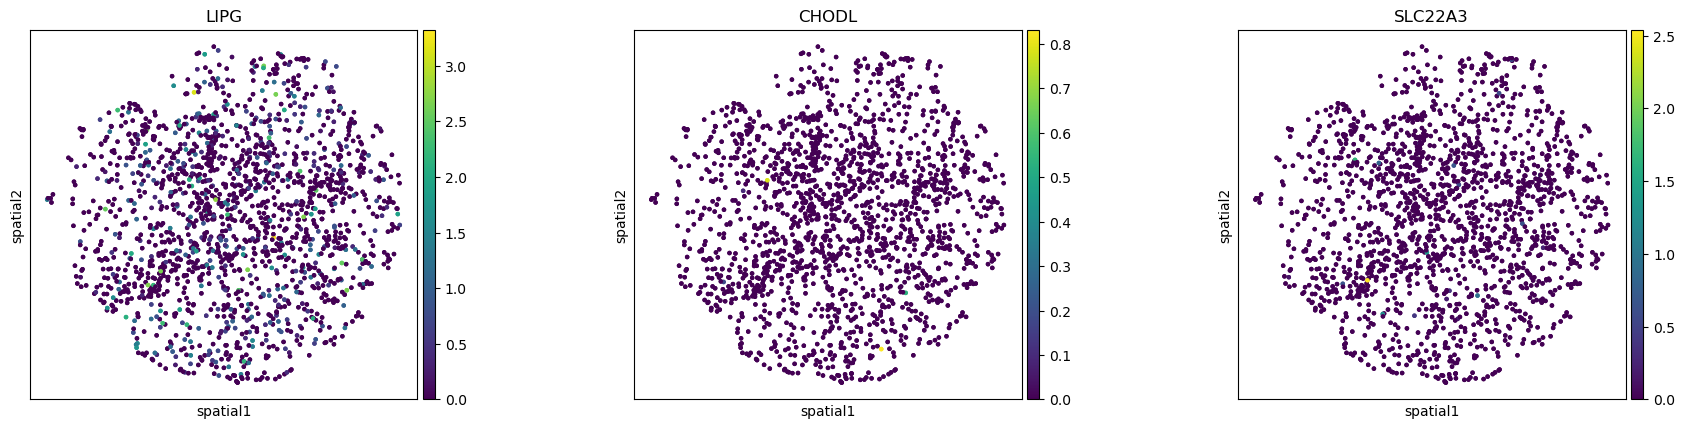

In [94]:
#sq.pl.spatial_scatter(ad_new_rc, color=["RGS13", "AFF2", "LHFPL2"], size=10, shape=None)
sq.pl.spatial_scatter(ad_new_rc, color=["LIPG", "CHODL", "SLC22A3"], size=20, shape=None)

Export Moran's I results as tables

I obtain different results depending on if using the Scaled Data assay or the Data assay from the Seurat object.

In [95]:
ad_orig_gt.uns["moranI"].to_csv(res_out_path+'moransI_genes_orig_gt_assayData.csv')

In [96]:
ad_orig_rc.uns["moranI"].to_csv(res_out_path+'moransI_genes_orig_rc_assayData.csv')

In [97]:
ad_new_rc.uns["moranI"].to_csv(res_out_path+'moransI_genes_new_rc_assayData.csv')

In [98]:
ad_orig_rc_morph.uns["moranI"].to_csv(res_out_path+'moransI_genes_orig_rc_morph_assayData.csv')

In [274]:
ad_orig_new_rc.uns["moranI"].to_csv(res_out_path+'moransI_genes_orig_new_rc_assayData.csv')

### Receptor-Ligand inference analysis

https://squidpy.readthedocs.io/en/stable/notebooks/examples/graph/compute_ligrec.html

In [99]:
rl_res_orig_gt = sq.gr.ligrec(
    ad_orig_gt,
    n_perms=100,
    cluster_key="node_type",
    copy=True,
    use_raw=False,
    transmitter_params={"categories": "ligand"},
    receiver_params={"categories": "receptor"},
)

  0%|          | 0/100 [00:00<?, ?permutation/s]

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [100]:
rl_res_orig_gt["means"].head()

cluster_1     B_germinal_center                                          \
cluster_2     B_germinal_center  B_memory   B_naive       FDC        NK   
source target                                                             
CCL2   MMP14            0.64133  0.825763   0.69359  0.718742  0.852851   
IL6ST  JAK2             0.01032         0         0  0.012915         0   
IFNG   IFNGR1           0.11903         0         0  0.178876  0.122404   
KITLG  KIT             0.003199  0.006152  0.003799  0.071882         0   
GHR    JAK2            0.172345         0         0   0.17494         0   

cluster_1                                                                     \
cluster_2         T_CD4     T_CD8 T_double_neg T_follicular_helper       mDC   
source target                                                                  
CCL2   MMP14   0.942849  0.978755     0.830583            0.688856  0.707895   
IL6ST  JAK2           0         0            0            0.012787         0   
IFNG   IFNGR1         0         0            0                   0         0   
KITLG  KIT     0.002231         0            0            0.003084         0   
GHR    JAK2           0         0            0            0.174812         0   

cluster_1      ...    plasma                                            \
cluster_2      ...       FDC        NK    T_CD4     T_CD8 T_double_neg   
source target  ...                                                       
CCL2   MMP14   ...  0.259113  0.393222  0.48322  0.519126     0.370954   
IL6ST  JAK2    ...  0.011007         0        0         0            0   
IFNG   IFNGR1  ...  0.185288  0.128815        0         0            0   
KITLG  KIT     ...         0         0        0         0            0   
GHR    JAK2    ...  0.093201         0        0         0            0   

cluster_1                                                                  
cluster_2     T_follicular_helper       mDC   myeloid       pDC    plasma  
source target                                                              
CCL2   MMP14             0.229227  0.248266  0.284632  0.381509  0.170857  
IL6ST  JAK2              0.010879         0  0.076013         0         0  
IFNG   IFNGR1                   0         0         0         0         0  
KITLG  KIT                      0         0         0         0         0  
GHR    JAK2              0.093073         0  0.158207         0         0  

[5 rows x 169 columns]

In [101]:
rl_res_orig_gt["pvalues"].head()

cluster_1     B_germinal_center                                         \
cluster_2     B_germinal_center B_memory B_naive  FDC   NK T_CD4 T_CD8   
source target                                                            
CCL2   MMP14                NaN      NaN     NaN  NaN  NaN   NaN   NaN   
IL6ST  JAK2                 NaN      NaN     NaN  NaN  NaN   NaN   NaN   
IFNG   IFNGR1               NaN      NaN     NaN  NaN  NaN   NaN   NaN   
KITLG  KIT                  NaN      NaN     NaN  NaN  NaN   NaN   NaN   
GHR    JAK2                 NaN      NaN     NaN  NaN  NaN   NaN   NaN   

cluster_1                                            ... plasma             \
cluster_2     T_double_neg T_follicular_helper  mDC  ...    FDC   NK T_CD4   
source target                                        ...                     
CCL2   MMP14           NaN                 NaN  NaN  ...    NaN  NaN   NaN   
IL6ST  JAK2            NaN                 NaN  NaN  ...    NaN  NaN   NaN   
IFNG   IFNGR1          NaN                 NaN  NaN  ...    NaN  NaN   NaN   
KITLG  KIT             NaN                 NaN  NaN  ...    NaN  NaN   NaN   
GHR    JAK2            NaN                 NaN  NaN  ...    NaN  NaN   NaN   

cluster_1                                                                      
cluster_2     T_CD8 T_double_neg T_follicular_helper  mDC myeloid  pDC plasma  
source target                                                                  
CCL2   MMP14    NaN          NaN                 NaN  NaN     NaN  NaN    NaN  
IL6ST  JAK2     NaN          NaN                 NaN  NaN     NaN  NaN    NaN  
IFNG   IFNGR1   NaN          NaN                 NaN  NaN     NaN  NaN    NaN  
KITLG  KIT      NaN          NaN                 NaN  NaN     NaN  NaN    NaN  
GHR    JAK2     NaN          NaN                 NaN  NaN     NaN  NaN    NaN  

[5 rows x 169 columns]

This only returns NaN p-values – is this a result of using scaled expression data? If it looks for mean expression values, then perhaps it will not work correctly(?). Update: Even with the normalized expression data it returns NaN p-values for all.

In [102]:
# sq.pl.ligrec(rl_res_orig_gt, source_groups="B_germinal_center", alpha=0.05)

#### Test LIANA+

https://liana-py.readthedocs.io/en/latest/index.html

https://liana-py.readthedocs.io/en/latest/notebooks/bivariate.html

In [103]:
import liana as li
from mudata import MuData

In [104]:
import decoupler as dc

In [105]:
ad_orig_gt.obs.head()


orig.ident  nCount_RNA  nFeature_RNA             barcode  \
AAACCCAAGCGCCTTG-1           0      2403.0          1480  AAACCCAAGCGCCTTG-1   
AAACCCAAGTGGACGT-1           0      6435.0          3252  AAACCCAAGTGGACGT-1   
AAACCCACAGAAGTGC-1           0     11403.0          4801  AAACCCACAGAAGTGC-1   
AAACCCAGTCATTGCA-1           0      4946.0          2691  AAACCCAGTCATTGCA-1   
AAACCCATCATCGCAA-1           0       965.0           714  AAACCCATCATCGCAA-1   

                      UMAP_1    UMAP_2          cell_type    spatial_x  \
AAACCCAAGCGCCTTG-1 -0.000162  5.448931              T_CD4  1733.213235   
AAACCCAAGTGGACGT-1  6.108639 -3.613436             plasma   519.377858   
AAACCCACAGAAGTGC-1  3.004497 -4.724403  B_germinal_center  1064.296595   
AAACCCAGTCATTGCA-1 -2.515251 -0.117800            B_naive  1740.127314   
AAACCCATCATCGCAA-1 -6.681471  2.266072           B_memory   930.600158   

                      spatial_y          node_type  type_prediction_score  \
AAACCCAAGCGCCTTG-1  1665.039824              T_CD4                   -1.0   
AAACCCAAGTGGACGT-1  2220.266321             plasma                   -1.0   
AAACCCACAGAAGTGC-1  2158.266703  B_germinal_center                   -1.0   
AAACCCAGTCATTGCA-1  3218.472808            B_naive                   -1.0   
AAACCCATCATCGCAA-1  2892.947737           B_memory                   -1.0   

                    RNA_snn_res.0.75  seurat_clusters  seurat_clusters_mod  \
AAACCCAAGCGCCTTG-1                 3                3                  4.0   
AAACCCAAGTGGACGT-1                 9                9                 10.0   
AAACCCACAGAAGTGC-1                 2                2                 19.0   
AAACCCAGTCATTGCA-1                 0                0                  1.0   
AAACCCATCATCGCAA-1                 0                0                  1.0   

                    percent.mt  
AAACCCAAGCGCCTTG-1    0.208073  
AAACCCAAGTGGACGT-1    0.186480  
AAACCCACAGAAGTGC-1    1.482066  
AAACCCAGTCATTGCA-1    1.273757  
AAACCCATCATCGCAA-1    0.207254

In [106]:
li.mt.bivariate.show_functions()


name                                   metadata  \
0          pearson   weighted Pearson correlation coefficient   
1         spearman  weighted Spearman correlation coefficient   
2           cosine                 weighted Cosine similarity   
3          jaccard                weighted Jaccard similarity   
4          product                    simple weighted product   
5     norm_product                normalized weighted product   
6           morans                                  Moran's R   
7  masked_spearman     masked & weighted Spearman correlation   

                                           reference  
0                                               None  
1                                               None  
2                                               None  
3                                               None  
4  If vars are z-scaled = Lee's static (Lee 2021;...  
5                                               None  
6  Li, Z., Wang, T., Liu, P. and Huang, Y., 2022....  
7  Ghazanfar, S., Lin, Y., Su, X., Lin, D.M., Pat...

**Orig, gt**

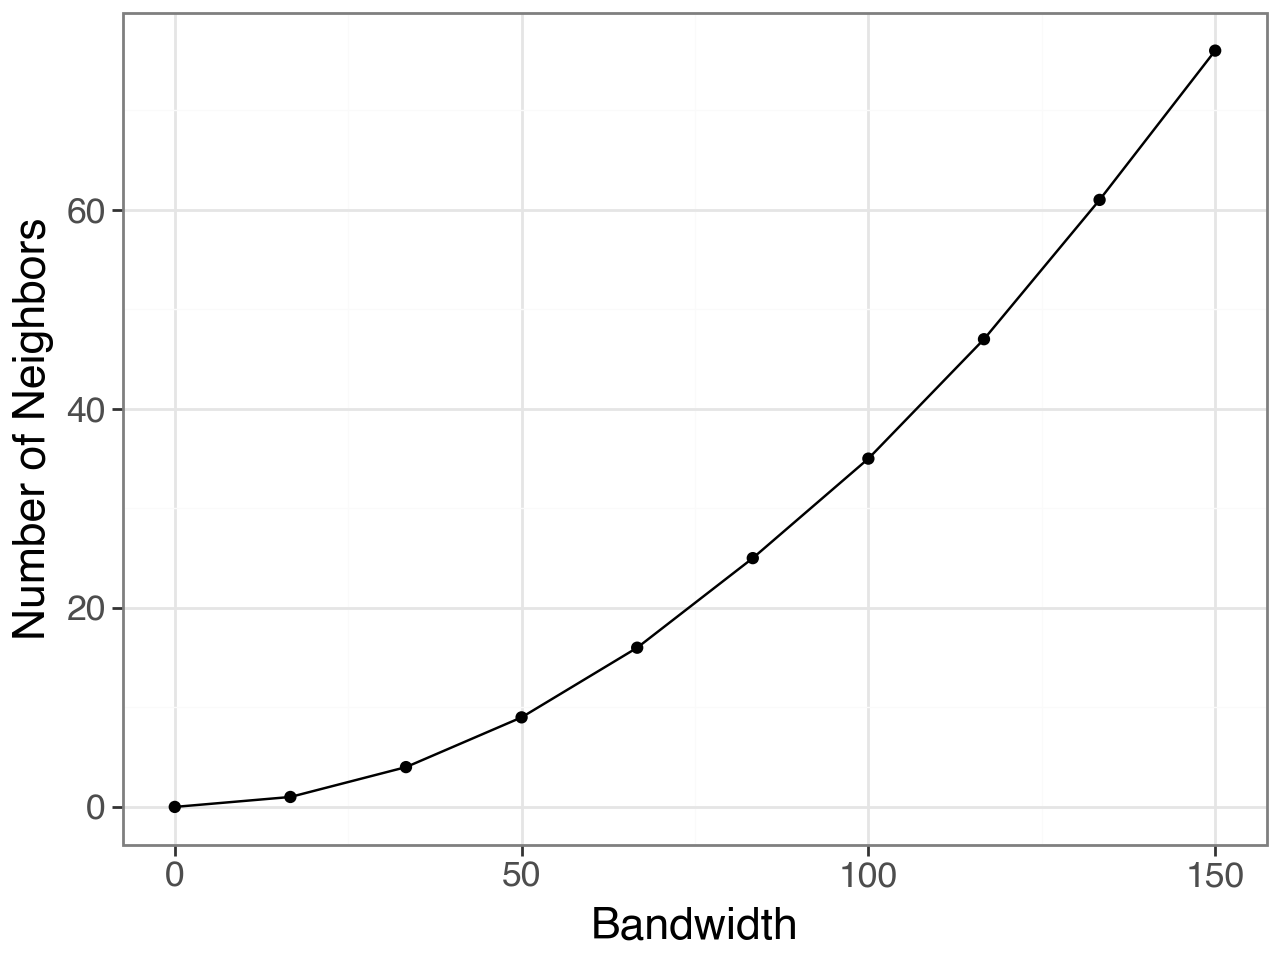

In [107]:
plot, _ = li.ut.query_bandwidth(coordinates=ad_orig_gt.obsm['spatial'], start=0, end=150, interval_n=10)
plot

In [108]:
li.ut.spatial_neighbors(ad_orig_gt, bandwidth=100, cutoff=0.1, kernel='gaussian', set_diag=True)

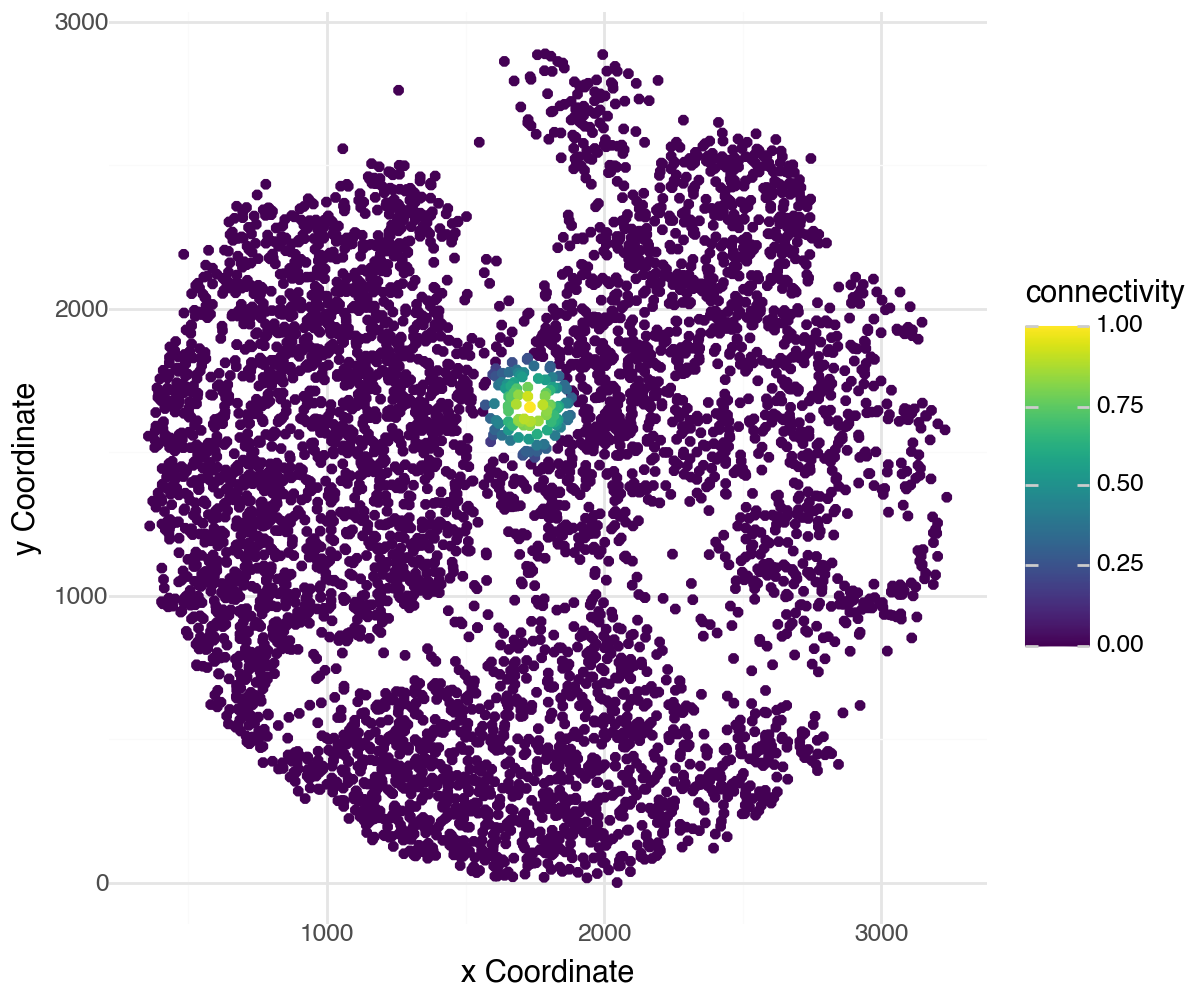

In [109]:
li.pl.connectivity(ad_orig_gt, idx=0, size=1.3, figure_size=(6, 5))

In [110]:
lrdata = li.mt.bivariate(
                ad_orig_gt,
                resource_name='consensus', # NOTE: uses HUMAN gene symbols!
                local_name='cosine', # Name of the function
                global_name="morans", # Name global function
                n_perms=100, # Number of permutations to calculate a p-value
                mask_negatives=True, # Whether to mask LowLow/NegativeNegative interactions
                add_categories=True, # Whether to add local categories to the results
                nz_prop=0.1, # Minimum expr. proportion for ligands/receptors and their subunits
                use_raw=False,
                verbose=True
                )

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 59.08it/s]


In [111]:
lrdata.var.sort_values("mean", ascending=False).head(10)

ligand receptor  ligand_means  ligand_props  receptor_means  \
interaction                                                               
ANXA2^TLR2   ANXA2     TLR2      0.555253      0.258924        0.155842   
CSF1^CSF2RA   CSF1   CSF2RA      0.339244      0.233884        0.402101   
NRG2^NRP2     NRG2     NRP2      0.326378      0.170662        0.435187   
TNC^PTPRB      TNC    PTPRB      0.217472      0.181318        0.104164   
NCAM1^GFRA1  NCAM1    GFRA1      0.182285      0.125910        0.282379   

             receptor_props    morans  morans_pvals      mean       std  
interaction                                                              
ANXA2^TLR2         0.116143  0.016444           0.0  0.241684  0.158950  
CSF1^CSF2RA        0.287693  0.016652           0.0  0.180071  0.116428  
NRG2^NRP2          0.218256 -0.010603           1.0  0.101521  0.086177  
TNC^PTPRB          0.105310 -0.025644           1.0  0.078712  0.075278  
NCAM1^GFRA1        0.211863  0.023720           0.0  0.063881  0.085269

In [112]:
lrdata.var.sort_values("std", ascending=False).head(10)

ligand receptor  ligand_means  ligand_props  receptor_means  \
interaction                                                               
ANXA2^TLR2   ANXA2     TLR2      0.555253      0.258924        0.155842   
CSF1^CSF2RA   CSF1   CSF2RA      0.339244      0.233884        0.402101   
NRG2^NRP2     NRG2     NRP2      0.326378      0.170662        0.435187   
NCAM1^GFRA1  NCAM1    GFRA1      0.182285      0.125910        0.282379   
TNC^PTPRB      TNC    PTPRB      0.217472      0.181318        0.104164   

             receptor_props    morans  morans_pvals      mean       std  
interaction                                                              
ANXA2^TLR2         0.116143  0.016444           0.0  0.241684  0.158950  
CSF1^CSF2RA        0.287693  0.016652           0.0  0.180071  0.116428  
NRG2^NRP2          0.218256 -0.010603           1.0  0.101521  0.086177  
NCAM1^GFRA1        0.211863  0.023720           0.0  0.063881  0.085269  
TNC^PTPRB          0.105310 -0.025644           1.0  0.078712  0.075278

In [113]:
lrdata.var.sort_values("morans", ascending=False).head(10)

ligand receptor  ligand_means  ligand_props  receptor_means  \
interaction                                                               
NCAM1^GFRA1  NCAM1    GFRA1      0.182285      0.125910        0.282379   
CSF1^CSF2RA   CSF1   CSF2RA      0.339244      0.233884        0.402101   
ANXA2^TLR2   ANXA2     TLR2      0.555253      0.258924        0.155842   
NRG2^NRP2     NRG2     NRP2      0.326378      0.170662        0.435187   
TNC^PTPRB      TNC    PTPRB      0.217472      0.181318        0.104164   

             receptor_props    morans  morans_pvals      mean       std  
interaction                                                              
NCAM1^GFRA1        0.211863  0.023720           0.0  0.063881  0.085269  
CSF1^CSF2RA        0.287693  0.016652           0.0  0.180071  0.116428  
ANXA2^TLR2         0.116143  0.016444           0.0  0.241684  0.158950  
NRG2^NRP2          0.218256 -0.010603           1.0  0.101521  0.086177  
TNC^PTPRB          0.105310 -0.025644           1.0  0.078712  0.075278

In [114]:
#sc.set_figure_params(dpi=80, dpi_save=300, format='png', frameon=False, transparent=True, figsize=[5,5])

In [128]:
lr_top_plot = lrdata.var.sort_values("mean", ascending=False).head(3).index.to_list()
lr_top_plot

['ANXA2^TLR2', 'CSF1^CSF2RA', 'NRG2^NRP2']

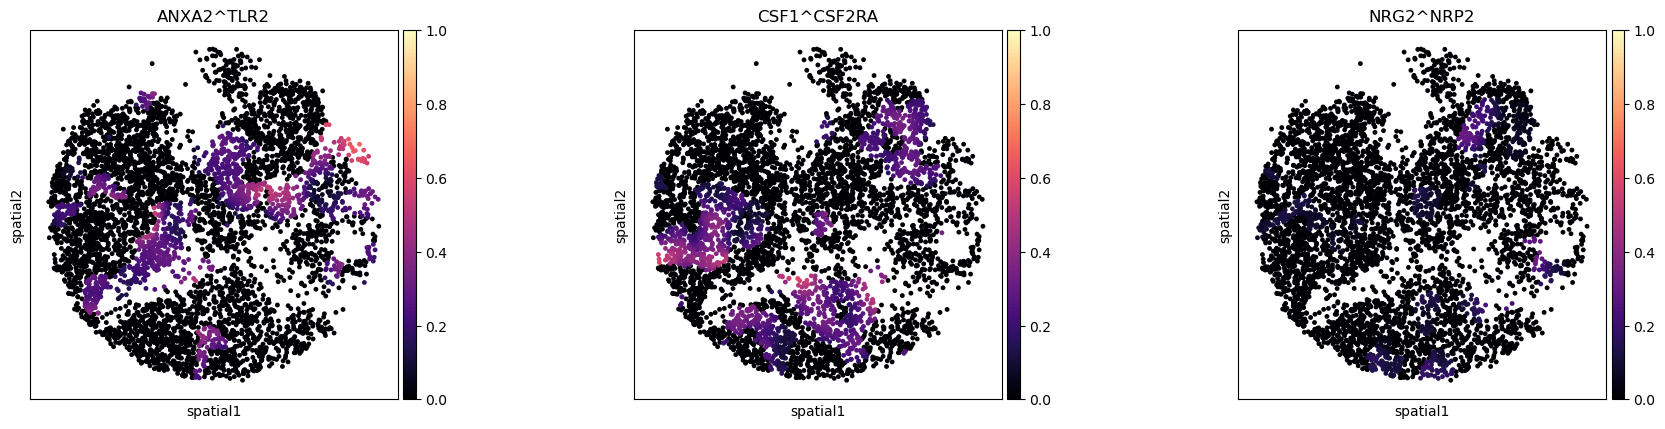

In [129]:
#sc.pl.spatial(lrdata, color=['XCL1^XCR1', 'EFNA5^EPHA3', 'LRIG1^MET'], size=1.4, vmax=1, cmap='magma', spot_size=25)
#sc.pl.spatial(lrdata, color=['ANOS1^SDC2', 'DCN^EGFR', 'NRG3^EGFR'], size=1.4, vmax=1, cmap='magma', spot_size=30)
#sc.pl.spatial(lrdata, color=['EFNA5^EPHA6', 'LAMA3^SDC2', 'APOE^SDC2'], size=1.4, vmax=1, cmap='magma', spot_size=30) # 2025-02-25, Data slot

sc.pl.spatial(lrdata, color=lr_top_plot, size=1.4, vmax=1, cmap='magma', spot_size=30) # 2025-03-04, Data slot

In [ ]:
#sc.pl.spatial(ad_orig_gt, color=['XCL1','XCR1','EFNA5','EPHA3','LRIG1','MET'], spot_size=30)
#sc.pl.spatial(ad_orig_gt, color=['ANOS1','SDC2','DCN','EGFR','NRG3'], spot_size=40)

#sc.pl.spatial(ad_orig_gt, color=['EFNA5','EPHA6','SDC2','LAMA3','APOE'], spot_size=40)

**Orig, rc**

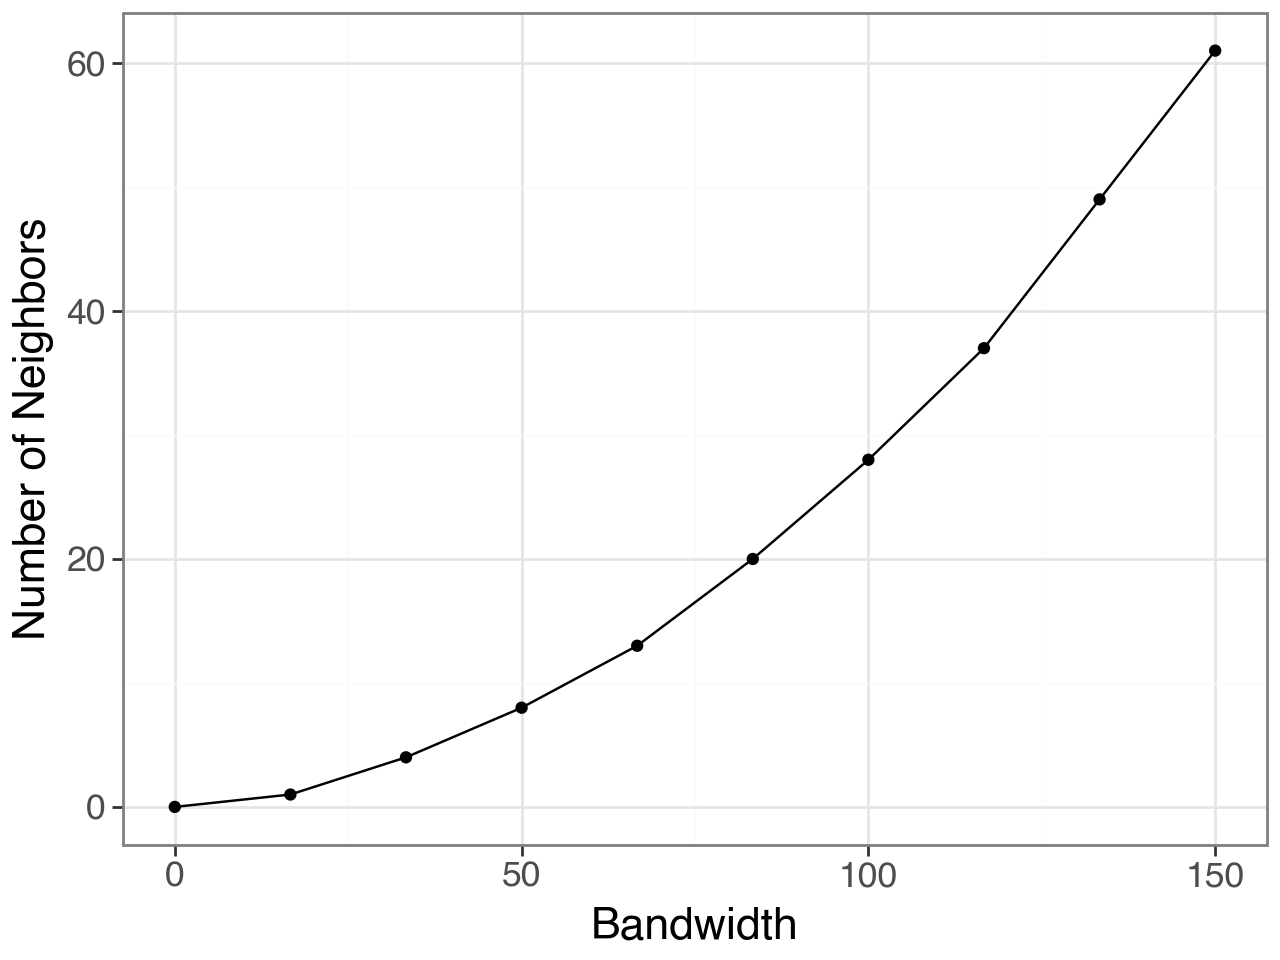

In [130]:
plot, _ = li.ut.query_bandwidth(coordinates=ad_orig_rc.obsm['spatial'], start=0, end=150, interval_n=10)
plot

In [131]:
li.ut.spatial_neighbors(ad_orig_rc, bandwidth=125, cutoff=0.1, kernel='gaussian', set_diag=True)

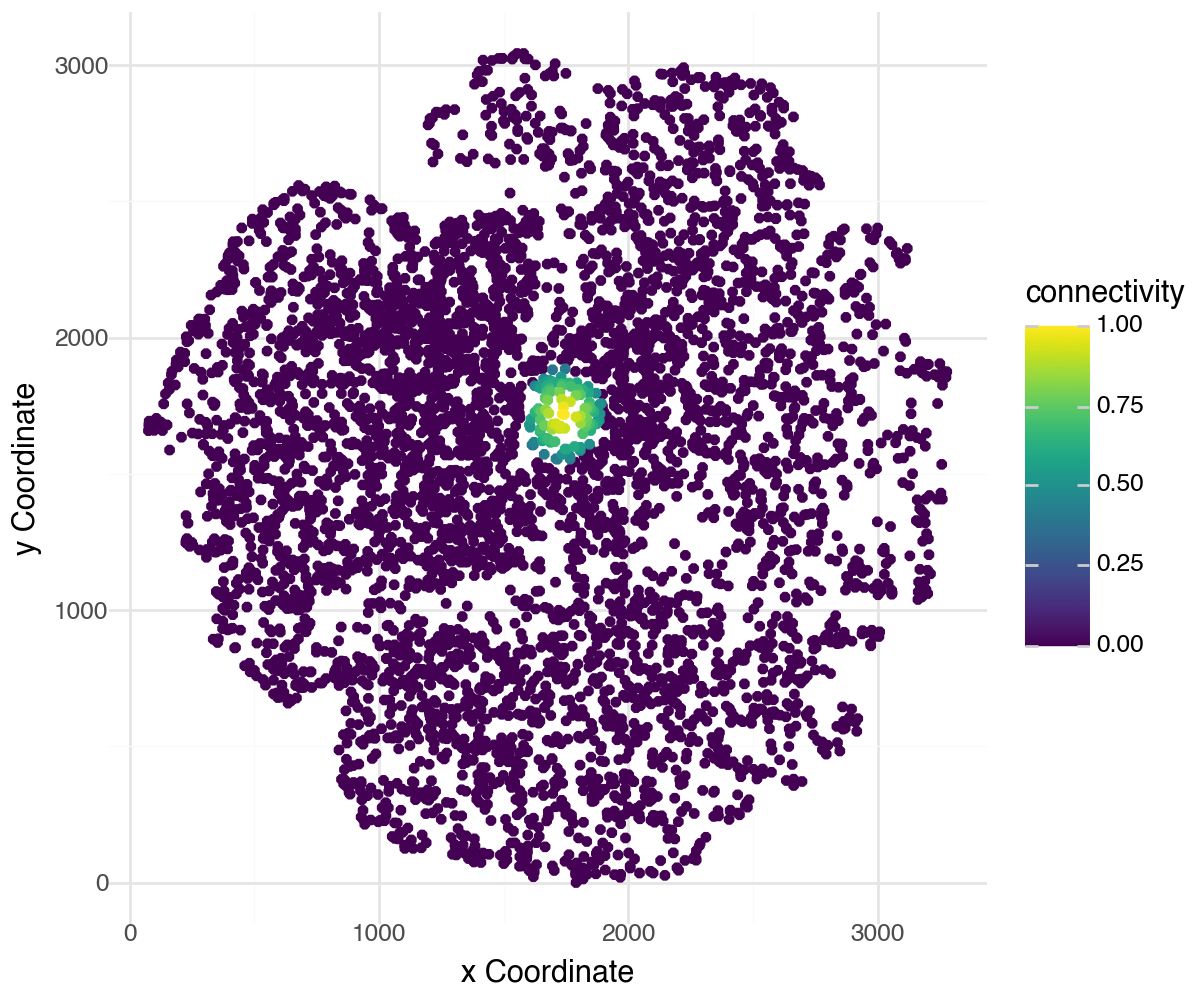

In [132]:
li.pl.connectivity(ad_orig_rc, idx=0, size=1.3, figure_size=(6, 5))

In [133]:
lrdata_orig_rc = li.mt.bivariate(
                    ad_orig_rc,
                    resource_name='consensus', # NOTE: uses HUMAN gene symbols!
                    local_name='cosine', # Name of the function
                    global_name="morans", # Name global function
                    n_perms=100, # Number of permutations to calculate a p-value
                    mask_negatives=True, # Whether to mask LowLow/NegativeNegative interactions
                    add_categories=True, # Whether to add local categories to the results
                    nz_prop=0.1, # Minimum expr. proportion for ligands/receptors and their subunits
                    use_raw=False,
                    verbose=True
                    )

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.56it/s]


In [134]:
lrdata_orig_rc.var.sort_values("mean", ascending=False).head(10)

ligand receptor  ligand_means  ligand_props  receptor_means  \
interaction                                                               
ANXA2^TLR2   ANXA2     TLR2      0.555253      0.258924        0.155842   
CSF1^CSF2RA   CSF1   CSF2RA      0.339244      0.233884        0.402101   
NRG2^NRP2     NRG2     NRP2      0.326378      0.170662        0.435187   
TNC^PTPRB      TNC    PTPRB      0.217472      0.181318        0.104164   
NCAM1^GFRA1  NCAM1    GFRA1      0.182285      0.125910        0.282379   

             receptor_props    morans  morans_pvals      mean       std  
interaction                                                              
ANXA2^TLR2         0.116143  0.015836           0.0  0.244383  0.157266  
CSF1^CSF2RA        0.287693  0.016025           0.0  0.178672  0.114565  
NRG2^NRP2          0.218256 -0.007274           1.0  0.099333  0.081310  
TNC^PTPRB          0.105310 -0.023299           1.0  0.081787  0.075133  
NCAM1^GFRA1        0.211863  0.020824           0.0  0.062245  0.070638

In [135]:
lrdata_orig_rc.var.sort_values("std", ascending=False).head(10)

ligand receptor  ligand_means  ligand_props  receptor_means  \
interaction                                                               
ANXA2^TLR2   ANXA2     TLR2      0.555253      0.258924        0.155842   
CSF1^CSF2RA   CSF1   CSF2RA      0.339244      0.233884        0.402101   
NRG2^NRP2     NRG2     NRP2      0.326378      0.170662        0.435187   
TNC^PTPRB      TNC    PTPRB      0.217472      0.181318        0.104164   
NCAM1^GFRA1  NCAM1    GFRA1      0.182285      0.125910        0.282379   

             receptor_props    morans  morans_pvals      mean       std  
interaction                                                              
ANXA2^TLR2         0.116143  0.015836           0.0  0.244383  0.157266  
CSF1^CSF2RA        0.287693  0.016025           0.0  0.178672  0.114565  
NRG2^NRP2          0.218256 -0.007274           1.0  0.099333  0.081310  
TNC^PTPRB          0.105310 -0.023299           1.0  0.081787  0.075133  
NCAM1^GFRA1        0.211863  0.020824           0.0  0.062245  0.070638

In [136]:
lrdata_orig_rc.var.sort_values("morans", ascending=False).head(10)

ligand receptor  ligand_means  ligand_props  receptor_means  \
interaction                                                               
NCAM1^GFRA1  NCAM1    GFRA1      0.182285      0.125910        0.282379   
CSF1^CSF2RA   CSF1   CSF2RA      0.339244      0.233884        0.402101   
ANXA2^TLR2   ANXA2     TLR2      0.555253      0.258924        0.155842   
NRG2^NRP2     NRG2     NRP2      0.326378      0.170662        0.435187   
TNC^PTPRB      TNC    PTPRB      0.217472      0.181318        0.104164   

             receptor_props    morans  morans_pvals      mean       std  
interaction                                                              
NCAM1^GFRA1        0.211863  0.020824           0.0  0.062245  0.070638  
CSF1^CSF2RA        0.287693  0.016025           0.0  0.178672  0.114565  
ANXA2^TLR2         0.116143  0.015836           0.0  0.244383  0.157266  
NRG2^NRP2          0.218256 -0.007274           1.0  0.099333  0.081310  
TNC^PTPRB          0.105310 -0.023299           1.0  0.081787  0.075133

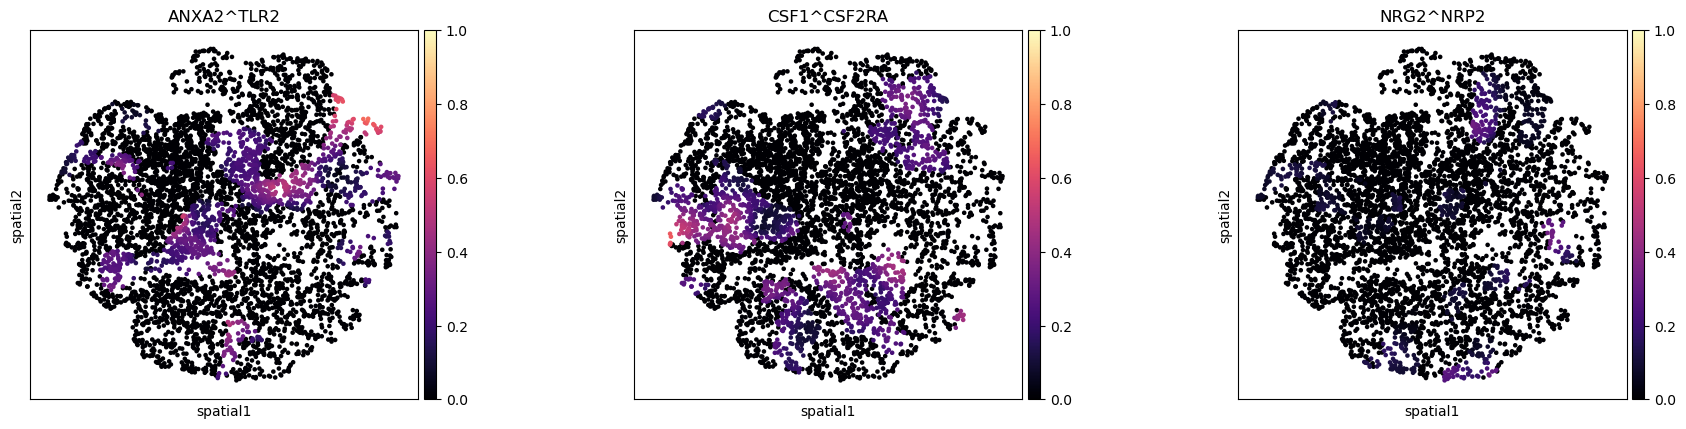

In [137]:
#sc.pl.spatial(lrdata_orig_rc, color=['ANOS1^SDC2', 'DCN^EGFR', 'NRG3^EGFR'], size=1.4, vmax=1, cmap='magma', spot_size=30)
#sc.pl.spatial(lrdata_orig_rc, color=['EFNA5^EPHA6', 'LAMA3^SDC2', 'APOE^SDC2'], size=1.4, vmax=1, cmap='magma', spot_size=30) # 2025-02-25, Data slot

sc.pl.spatial(lrdata_orig_rc, color=lr_top_plot, size=1.4, vmax=1, cmap='magma', spot_size=30) # 2025-03-04, Data slot

**Orig, rc-morph**

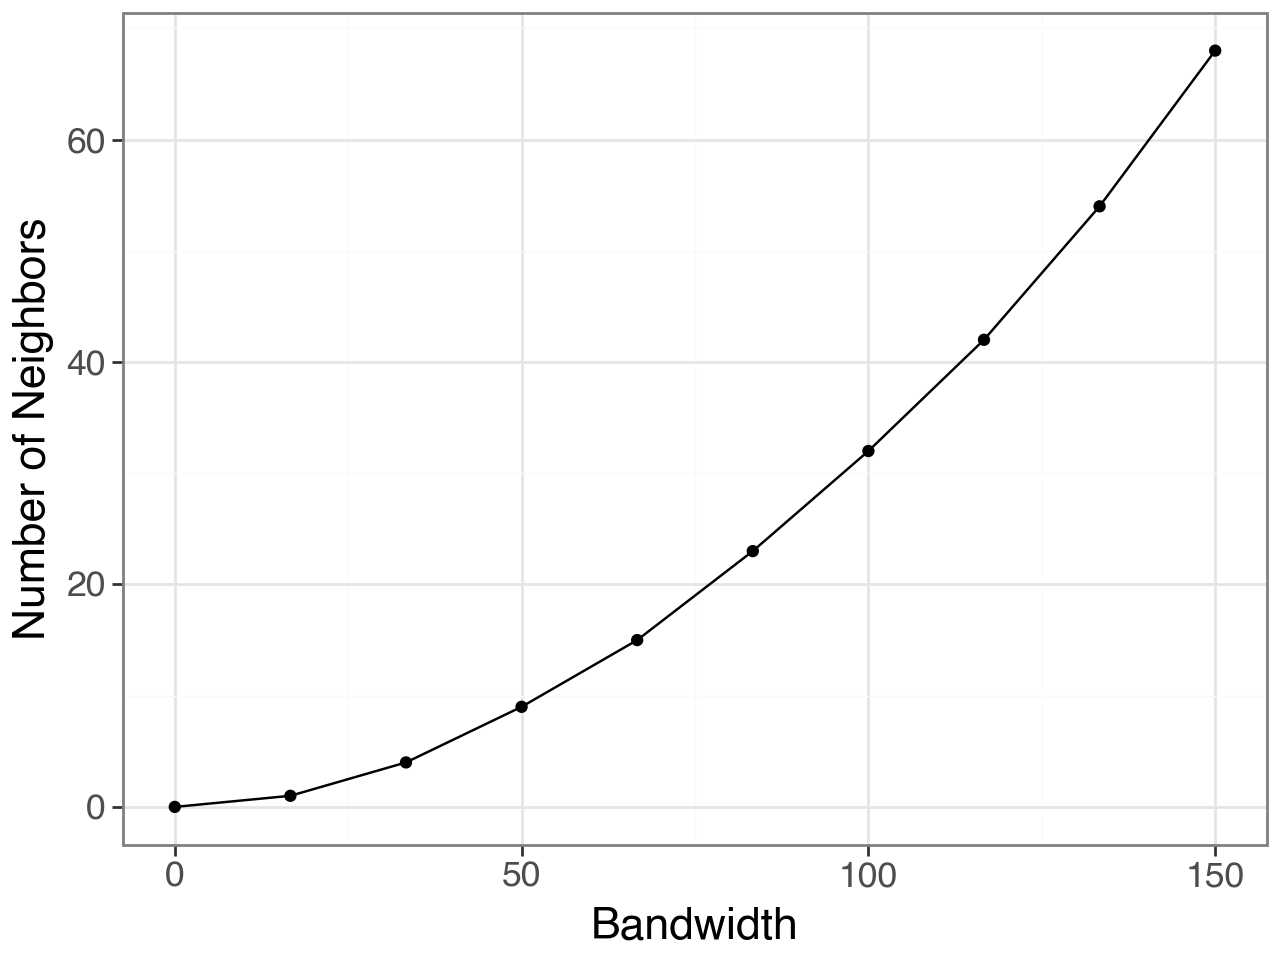

In [138]:
plot, _ = li.ut.query_bandwidth(coordinates=ad_orig_rc_morph.obsm['spatial'], start=0, end=150, interval_n=10)
plot

In [139]:
li.ut.spatial_neighbors(ad_orig_rc_morph, bandwidth=125, cutoff=0.1, kernel='gaussian', set_diag=True)

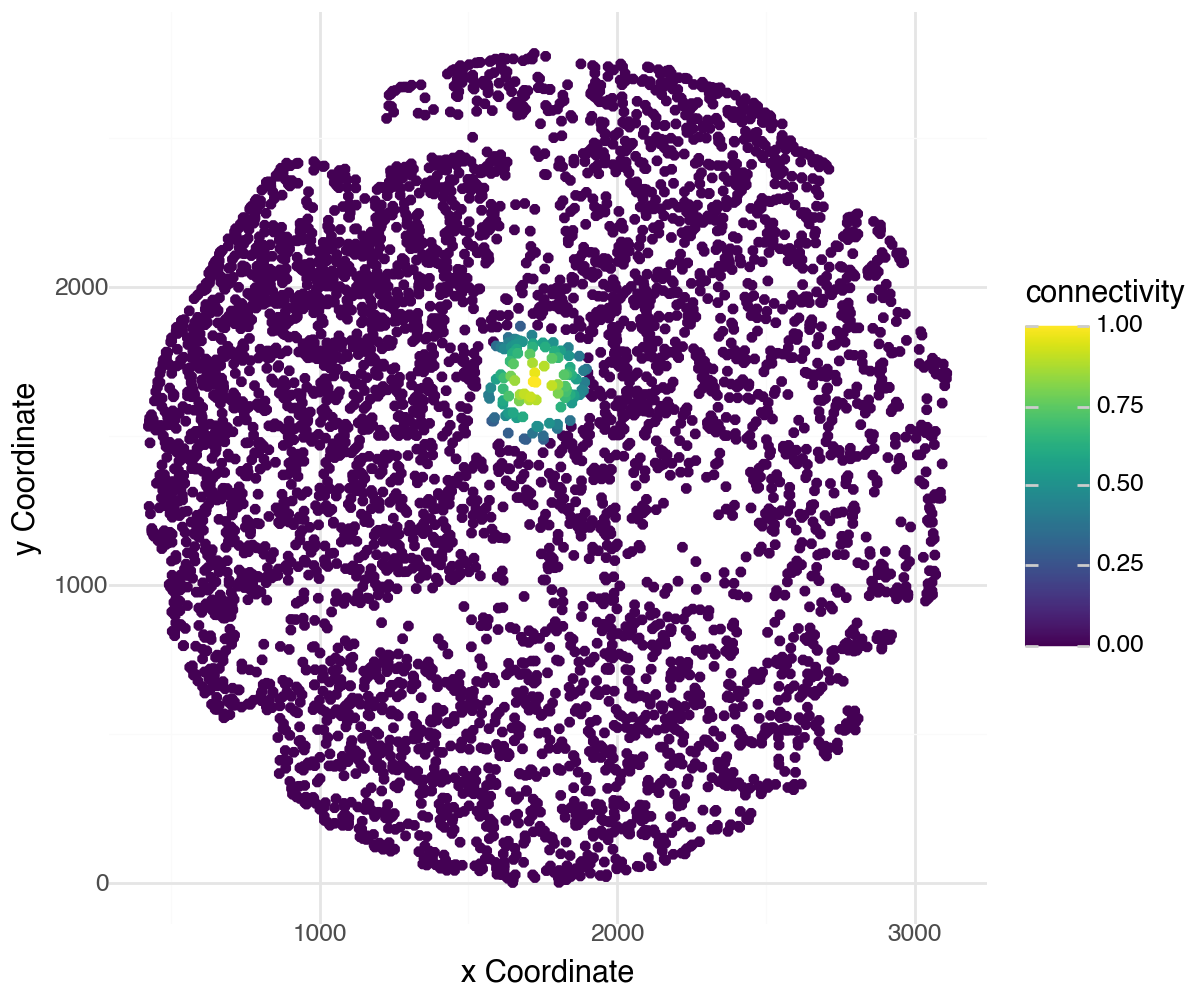

In [140]:
li.pl.connectivity(ad_orig_rc_morph, idx=0, size=1.3, figure_size=(6, 5))

In [141]:
lrdata_orig_rc_morph = li.mt.bivariate(
    ad_orig_rc_morph,
    resource_name='consensus', # NOTE: uses HUMAN gene symbols!
    local_name='cosine', # Name of the function
    global_name="morans", # Name global function
    n_perms=100, # Number of permutations to calculate a p-value
    mask_negatives=True, # Whether to mask LowLow/NegativeNegative interactions
    add_categories=True, # Whether to add local categories to the results
    nz_prop=0.1, # Minimum expr. proportion for ligands/receptors and their subunits
    use_raw=False,
    verbose=True
    )

/opt/homebrew/anaconda3/envs/squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.32it/s]


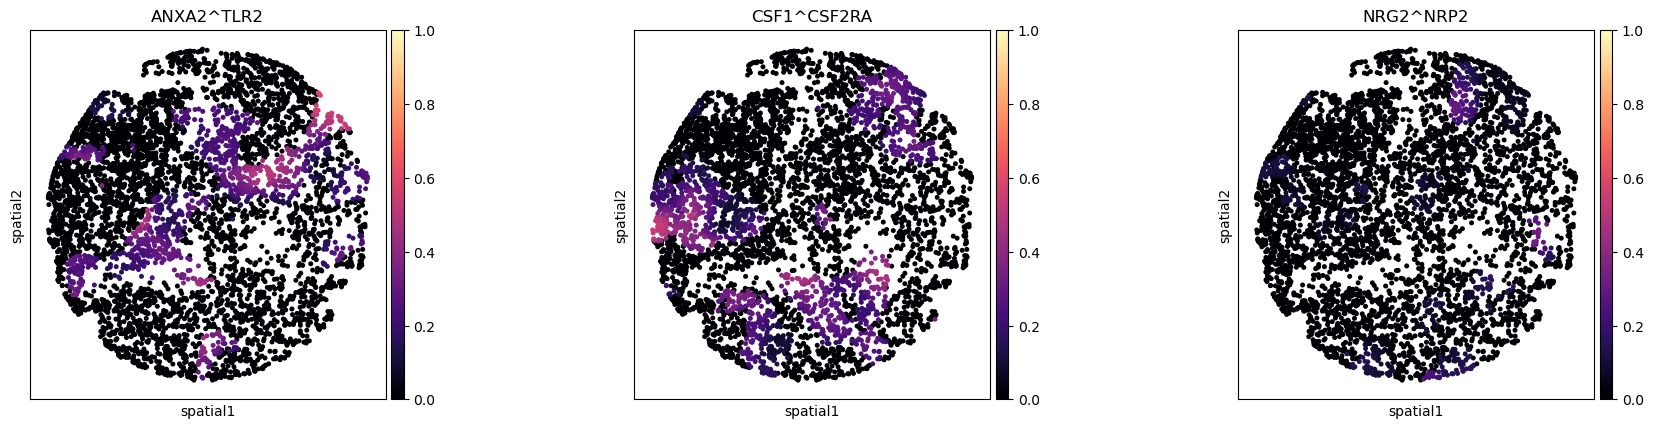

In [142]:
# sc.pl.spatial(lrdata_orig_rc_morph, color=['ANOS1^SDC2', 'DCN^EGFR', 'NRG3^EGFR'], size=1.4, vmax=1, cmap='magma', spot_size=30)
# sc.pl.spatial(lrdata_orig_rc_morph, color=['EFNA5^EPHA6', 'LAMA3^SDC2', 'APOE^SDC2'], size=1.4, vmax=1, cmap='magma', spot_size=30) # 2025-02-25, Data slot

sc.pl.spatial(lrdata_orig_rc_morph, color=lr_top_plot, size=1.4, vmax=1, cmap='magma', spot_size=30) # 2025-03-04, Data slot

Export LIANA receptor-ligand results

In [143]:
lrdata.var.to_csv(res_out_path+'liana_bivariate_lrres_orig_gt_assayData.csv')
lrdata_orig_rc.var.to_csv(res_out_path+'liana_bivariate_lrres_orig_rc_assayData.csv')
lrdata_orig_rc_morph.var.to_csv(res_out_path+'liana_bivariate_lrres_orig_rc_morph_assayData.csv')

---